# Project 2
## Hypothesis: Across the United States, mortality rates associated with cold weather are higher than mortality rates associated with hot weather.
### By Tim and Ted

### Exploratory Visuals in QGIS
![Crude Total Heat Rate by State 1999-2020](data/crude_heat_rate.png)
![Crude Total Cold Rate by State 1999-2020](data/crude_cold_rate.png)
![Temperature Average by State 1999-2020](data/avg_temp.png)

These first visuals were to just give us a sense of what the data looks like and how we can manipulate it or use it.

- The first one shows a heat map of mortality rate due to heat across the entiremortality data set.
- The second one show a heat map of mortality rate due to cold across the entire mortality data set.
- The third one shows the average daily temperature for a specific date (1999-01-01) joined with the state shapefile. QGIS default join was on the first date available in the temperature dataset (PRISM Weather Download Tool).


## Merge cold deaths and heat deaths with state boundaries (initial exploration)

**Cold-related deaths** were identified using the following ICD-10 codes:  
- **X31:** Exposure to excessive natural cold  
- **T68:** Hypothermia  

**Heat-related deaths** were identified using the following ICD-10 codes:  
- **X30:** Exposure to excessive natural heat  
- **T67:** Effects of heat and light

These were preprocessed/exported using the CDC WONDER tool.

In [199]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import re
import libpysal
from esda import Moran
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.patches as patches
import warnings
warnings.filterwarnings("ignore", "This figure includes Axes that are not compatible with tight_layout")


In [200]:
cold = pd.read_csv("/home/jovyan/Project2/data/mcod_cold.csv")

In [201]:
cold.rename(columns={"Deaths":"Cold Deaths"}, inplace=True) #rename columns
cold.head() 

,Notes,State,State Code,Cold Deaths,Population,Crude Rate
0,NaN,Alabama,1.0,388.0,103604166.0,0.4
1,NaN,Alaska,2.0,647.0,15300884.0,4.2
2,NaN,Arizona,4.0,864.0,138079425.0,0.6
3,NaN,Arkansas,5.0,319.0,63181817.0,0.5
4,NaN,California,6.0,1743.0,815706063.0,0.2


In [202]:
heat = pd.read_csv("/home/jovyan/Project2/data/mcod_heat.csv")

In [203]:
heat.rename(columns={"Deaths":"Heat Deaths"}, inplace=True) 
heat.head()

,Notes,State,State Code,Heat Deaths,Population,Crude Rate
0,NaN,Alabama,1.0,238.0,103604166.0,0.2
1,NaN,Alaska,2.0,28.0,15300884.0,0.2
2,NaN,Arizona,4.0,2462.0,138079425.0,1.8
3,NaN,Arkansas,5.0,271.0,63181817.0,0.4
4,NaN,California,6.0,1481.0,815706063.0,0.2


In [204]:
merged = pd.merge(heat, cold, on="State Code", suffixes=(("_cold"), ("_heat"))) #merging hot and cold deaths

In [154]:
merged.head()

,Notes_cold,State_cold,State Code,Heat Deaths,Population_cold,Crude Rate_cold,Notes_heat,State_heat,Cold Deaths,Population_heat,Crude Rate_heat
0,NaN,Alabama,1.0,238.0,103604166.0,0.2,NaN,Alabama,388.0,103604166.0,0.4
1,NaN,Alaska,2.0,28.0,15300884.0,0.2,NaN,Alaska,647.0,15300884.0,4.2
2,NaN,Arizona,4.0,2462.0,138079425.0,1.8,NaN,Arizona,864.0,138079425.0,0.6
3,NaN,Arkansas,5.0,271.0,63181817.0,0.4,NaN,Arkansas,319.0,63181817.0,0.5
4,NaN,California,6.0,1481.0,815706063.0,0.2,NaN,California,1743.0,815706063.0,0.2


In [155]:
merged = merged.drop(columns=["State_heat", "Population_cold", "Notes_cold", "Notes_heat", "Crude Rate_cold", "Crude Rate_heat"]) #dropping columns we dont need

In [156]:
merged.rename(columns={"State_cold":"State", "Population_heat":"Population", "State Code":"FIPS"}, inplace=True) #rename columns

In [157]:
merged.head()

,State,FIPS,Heat Deaths,Cold Deaths,Population
0,Alabama,1.0,238.0,388.0,103604166.0
1,Alaska,2.0,28.0,647.0,15300884.0
2,Arizona,4.0,2462.0,864.0,138079425.0
3,Arkansas,5.0,271.0,319.0,63181817.0
4,California,6.0,1481.0,1743.0,815706063.0


In [158]:
merged["cold_rate"] = (merged["Cold Deaths"] / merged["Population"]) * 100000 # recalculating death rates 
merged["heat_rate"] = (merged["Heat Deaths"] / merged["Population"]) * 100000

In [159]:
merged[merged["Heat Deaths"].isna()].head() # checking which columns have nan


,State,FIPS,Heat Deaths,Cold Deaths,Population,cold_rate,heat_rate
111,NaN,NaN,NaN,33418.0,6.746357e+09,0.495349,NaN
112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
merged[merged["Cold Deaths"].isna()].head()

,State,FIPS,Heat Deaths,Cold Deaths,Population,cold_rate,heat_rate
52,NaN,NaN,15822.0,NaN,NaN,NaN,NaN
53,NaN,NaN,15822.0,NaN,NaN,NaN,NaN
54,NaN,NaN,15822.0,NaN,NaN,NaN,NaN
55,NaN,NaN,15822.0,NaN,NaN,NaN,NaN
56,NaN,NaN,15822.0,NaN,NaN,NaN,NaN


In [161]:
merged.to_csv("/home/jovyan/Project2/data/intermediary/merged_death")

In [162]:
states = gpd.read_file("/home/jovyan/Project2/data/states/s_05mr24.shp")

In [163]:
states.head()

,STATE,NAME,FIPS,LON,LAT,geometry
0,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ..."
1,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499..."
2,AS,American Samoa,60,-170.37215,-14.26486,"MULTIPOLYGON (((-168.14924 -14.53377, -168.148..."
3,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-110.49090 37.00361, -110.48750 37.0..."
4,CA,California,06,-119.60818,37.24537,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263..."


In [164]:
merged["FIPS"] = (
    merged["FIPS"]
    .fillna("")              # Replace NaN with empty string
    .astype(str)
    .str.replace(".0", "", regex=False)  # Remove decimal part if any
    .str.zfill(2)
)
states["FIPS"] = states["FIPS"].astype(str).str.zfill(2)
gdf = states.merge(merged, on="FIPS", how="left")

In [165]:
gdf.head()

,STATE,NAME,FIPS,LON,LAT,geometry,State,Heat Deaths,Cold Deaths,Population,cold_rate,heat_rate
0,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ...",Alabama,238.0,388.0,103604166.0,0.374502,0.229720
1,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499...",Arkansas,271.0,319.0,63181817.0,0.504892,0.428921
2,AS,American Samoa,60,-170.37215,-14.26486,"MULTIPOLYGON (((-168.14924 -14.53377, -168.148...",NaN,NaN,NaN,NaN,NaN,NaN
3,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-110.49090 37.00361, -110.48750 37.0...",Arizona,2462.0,864.0,138079425.0,0.625727,1.783032
4,CA,California,06,-119.60818,37.24537,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263...",California,1481.0,1743.0,815706063.0,0.213680,0.181560


In [166]:
gdf.to_file("/home/jovyan/Project2/data/intermediary/merged_death_rates.shp")

/tmp/ipykernel_142/1970897145.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("/home/jovyan/Project2/data/intermediary/merged_death_rates.shp")


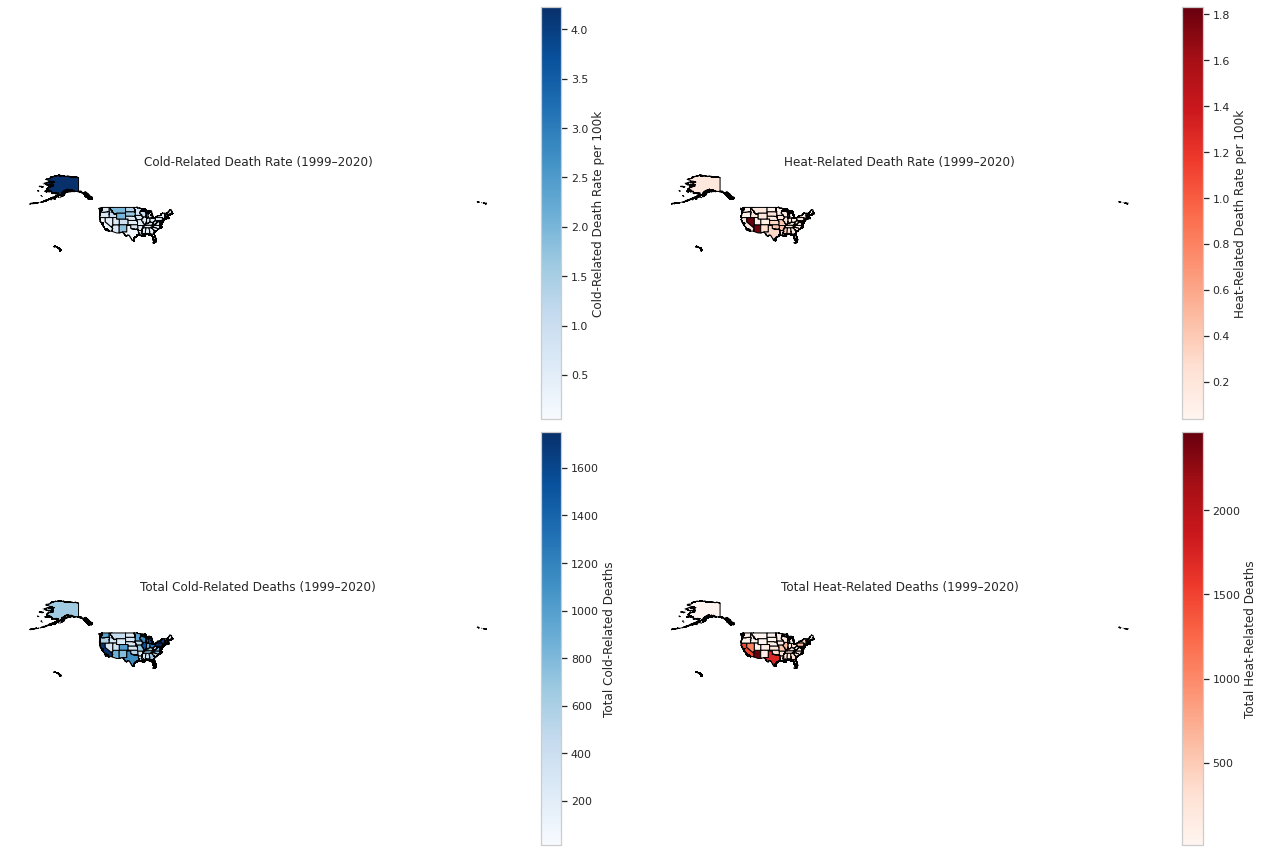

In [167]:
# Create 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --- Top row: Rates ---
gdf.plot(column='cold_rate',
         cmap='Blues',
         legend=True,
         legend_kwds={'label': "Cold-Related Death Rate per 100k"},
         edgecolor='black',
         ax=axes[0, 0])
axes[0, 0].set_title("Cold-Related Death Rate (1999–2020)")
axes[0, 0].axis('off')

gdf.plot(column='heat_rate',
         cmap='Reds',
         legend=True,
         legend_kwds={'label': "Heat-Related Death Rate per 100k"},
         edgecolor='black',
         ax=axes[0, 1])
axes[0, 1].set_title("Heat-Related Death Rate (1999–2020)")
axes[0, 1].axis('off')

# --- Bottom row: Raw Death Counts ---
gdf.plot(column='Cold Deaths',
         cmap='Blues',
         legend=True,
         legend_kwds={'label': "Total Cold-Related Deaths"},
         edgecolor='black',
         ax=axes[1, 0])
axes[1, 0].set_title("Total Cold-Related Deaths (1999–2020)")
axes[1, 0].axis('off')

gdf.plot(column='Heat Deaths',
         cmap='Reds',
         legend=True,
         legend_kwds={'label': "Total Heat-Related Deaths"},
         edgecolor='black',
         ax=axes[1, 1])
axes[1, 1].set_title("Total Heat-Related Deaths (1999–2020)")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## First look at the data

Here is our first look at the data. So far all we have done is format the data by renaming and dropping certain columns, merged the hot and cold death tables based on the state code (FIPS), and recalculated the death rates for each state (because some of the rates were labeled "unreliable"). Then, merged the table with a state shape file in order to add the geometry for each state and then plot it.

**This first view is okay but it is quite zoomed out and hard to see the details of the plots.** We will have to either zoom in or drop the geometry on the right of the plot to automatically zoom it in. We have also not pulled in the weather data yet, some ideas for this would be a supplemental scatterplot with number of deaths or death rate, and number of days below freezing or above 90 degrees. We will also likely trash the total death choropleths because it does not account for population like death rate does. Another approach is looking at rates at a county level. However, this will likely result in too many supressed values.

In [205]:
cold_county = pd.read_csv("/home/jovyan/Project2/data/mcod_county_cold.csv")
heat_county = pd.read_csv("/home/jovyan/Project2/data/mcod_county_heat.csv")
merged_county = pd.merge(cold_county, heat_county, on="County Code", suffixes=(("_cold"), ("_heat"))) #merging hot and cold deaths
merged_county.head()

,Notes_cold,State_cold,State Code_cold,County_cold,County Code,Deaths_cold,Population_cold,Crude Rate_cold,Notes_heat,State_heat,State Code_heat,County_heat,Deaths_heat,Population_heat,Crude Rate_heat
0,NaN,Alabama,1.0,"Autauga County, AL",1001.0,Suppressed,1143294.0,Suppressed,NaN,Alabama,1.0,"Autauga County, AL",Suppressed,1143294.0,Suppressed
1,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,15,3987384.0,Unreliable,NaN,Alabama,1.0,"Baldwin County, AL",Suppressed,3987384.0,Suppressed
2,NaN,Alabama,1.0,"Barbour County, AL",1005.0,Suppressed,599031.0,Suppressed,NaN,Alabama,1.0,"Barbour County, AL",0,599031.0,Unreliable
3,NaN,Alabama,1.0,"Bibb County, AL",1007.0,Suppressed,487078.0,Suppressed,NaN,Alabama,1.0,"Bibb County, AL",0,487078.0,Unreliable
4,NaN,Alabama,1.0,"Blount County, AL",1009.0,Suppressed,1229334.0,Suppressed,NaN,Alabama,1.0,"Blount County, AL",Suppressed,1229334.0,Suppressed


In [169]:
merged_county.rename(columns={"County_cold":"County", "State_cold":"State", "State Code_cold":"State Code", "Population_cold":"Population"}, inplace=True) #rename columns
merged_county.columns.to_list()

['Notes_cold',
 'State',
 'State Code',
 'County',
 'County Code',
 'Deaths_cold',
 'Population',
 'Crude Rate_cold',
 'Notes_heat',
 'State_heat',
 'State Code_heat',
 'County_heat',
 'Deaths_heat',
 'Population_heat',
 'Crude Rate_heat']

In [170]:
merged_county = merged_county.drop(columns=["Crude Rate_cold", "Notes_heat", "State_heat", "State Code_heat", "County_heat", "Population_heat", "Crude Rate_heat"])
merged_county.head()

,Notes_cold,State,State Code,County,County Code,Deaths_cold,Population,Deaths_heat
0,NaN,Alabama,1.0,"Autauga County, AL",1001.0,Suppressed,1143294.0,Suppressed
1,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,15,3987384.0,Suppressed
2,NaN,Alabama,1.0,"Barbour County, AL",1005.0,Suppressed,599031.0,0
3,NaN,Alabama,1.0,"Bibb County, AL",1007.0,Suppressed,487078.0,0
4,NaN,Alabama,1.0,"Blount County, AL",1009.0,Suppressed,1229334.0,Suppressed


In [171]:
# Replace 'Suppressed' strings with 1
merged_county['Deaths_cold'] = merged_county['Deaths_cold'].replace('Suppressed', 1)
merged_county['Deaths_heat'] = merged_county['Deaths_heat'].replace('Suppressed', 1)

In [172]:
# Convert the column to numeric
merged_county['Deaths_cold'] = pd.to_numeric(merged_county['Deaths_cold'])
merged_county['Deaths_heat'] = pd.to_numeric(merged_county['Deaths_heat'])
merged_county['Population'] = pd.to_numeric(merged_county['Population'])

merged_county["cold_rate"] = (merged_county["Deaths_cold"] / merged_county["Population"]) * 100000 #recalculating death rates 
merged_county["heat_rate"] = (merged_county["Deaths_heat"] / merged_county["Population"]) * 100000
merged_county.head()

,Notes_cold,State,State Code,County,County Code,Deaths_cold,Population,Deaths_heat,cold_rate,heat_rate
0,NaN,Alabama,1.0,"Autauga County, AL",1001.0,1.0,1143294.0,1.0,0.087467,0.087467
1,NaN,Alabama,1.0,"Baldwin County, AL",1003.0,15.0,3987384.0,1.0,0.376186,0.025079
2,NaN,Alabama,1.0,"Barbour County, AL",1005.0,1.0,599031.0,0.0,0.166936,0.000000
3,NaN,Alabama,1.0,"Bibb County, AL",1007.0,1.0,487078.0,0.0,0.205306,0.000000
4,NaN,Alabama,1.0,"Blount County, AL",1009.0,1.0,1229334.0,1.0,0.081345,0.081345


In [173]:
# Convert to integer
merged_county['County Code'] = merged_county['County Code'].fillna(0).astype(int)
merged_county['State Code'] = merged_county['State Code'].fillna(0).astype(int)

# Convert County Code to string and remove extra leading '1' if present
merged_county['County Code'] = merged_county['County Code'].astype(str).apply(lambda x: x[-3:] if len(x) > 3 else x)

merged_county.head()

,Notes_cold,State,State Code,County,County Code,Deaths_cold,Population,Deaths_heat,cold_rate,heat_rate
0,NaN,Alabama,1,"Autauga County, AL",001,1.0,1143294.0,1.0,0.087467,0.087467
1,NaN,Alabama,1,"Baldwin County, AL",003,15.0,3987384.0,1.0,0.376186,0.025079
2,NaN,Alabama,1,"Barbour County, AL",005,1.0,599031.0,0.0,0.166936,0.000000
3,NaN,Alabama,1,"Bibb County, AL",007,1.0,487078.0,0.0,0.205306,0.000000
4,NaN,Alabama,1,"Blount County, AL",009,1.0,1229334.0,1.0,0.081345,0.081345


In [174]:
counties = gpd.read_file("/home/jovyan/Project2/data/counties")

In [175]:
print(counties.columns.to_list())

['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry']


In [176]:
# Make sure codes are strings and zero-padded
counties['STATEFP'] = counties['STATEFP'].astype(str).str.zfill(2)
counties['COUNTYFP'] = counties['COUNTYFP'].astype(str).str.zfill(3)

merged_county['STATEFP'] = merged_county['State Code'].astype(str).str.zfill(2)
merged_county['COUNTYFP'] = merged_county['County Code'].astype(str).str.zfill(3)
print(merged_county[['State Code','County Code','STATEFP','COUNTYFP']].head(10))

   State Code County Code STATEFP COUNTYFP
0           1         001      01      001
1           1         003      01      003
2           1         005      01      005
3           1         007      01      007
4           1         009      01      009
5           1         011      01      011
6           1         013      01      013
7           1         015      01      015
8           1         017      01      017
9           1         019      01      019


In [177]:
gdf_county = counties.merge(
    merged_county,
    on=['STATEFP', 'COUNTYFP'],
    how='left' 
)
gdf_county

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,Notes_cold,State,State Code,County,County Code,Deaths_cold,Population,Deaths_heat,cold_rate,heat_rate
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,NaN,Nebraska,31.0,"Cuming County, NE",039,1.0,205910.0,0.0,0.485649,0.000000
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,...,NaN,Washington,53.0,"Wahkiakum County, WA",069,1.0,88261.0,0.0,1.133003,0.000000
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,...,NaN,New Mexico,35.0,"DeBaca County, NM",011,0.0,43429.0,0.0,0.000000,0.000000
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,NaN,Nebraska,31.0,"Lancaster County, NE",109,29.0,6273303.0,1.0,0.462276,0.015941
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,...,NaN,Nebraska,31.0,"Nuckolls County, NE",129,0.0,100488.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,13,123,00351260,13123,Gilmer,Gilmer County,06,H1,G4020,None,...,NaN,Georgia,13.0,"Gilmer County, GA",123,1.0,611750.0,0.0,0.163465,0.000000
3229,27,135,00659513,27135,Roseau,Roseau County,06,H1,G4020,None,...,NaN,Minnesota,27.0,"Roseau County, MN",135,1.0,347282.0,1.0,0.287950,0.287950
3230,28,089,00695768,28089,Madison,Madison County,06,H1,G4020,298,...,NaN,Mississippi,28.0,"Madison County, MS",089,1.0,2039178.0,1.0,0.049039,0.049039
3231,48,227,01383899,48227,Howard,Howard County,06,H1,G4020,None,...,NaN,Texas,48.0,"Howard County, TX",227,1.0,768775.0,1.0,0.130077,0.130077


In [178]:
print(gdf_county[['STATEFP','COUNTYFP','NAME','Deaths_cold','Deaths_heat']].head(20))

   STATEFP COUNTYFP         NAME  Deaths_cold  Deaths_heat
0       31      039       Cuming          1.0          0.0
1       53      069    Wahkiakum          1.0          0.0
2       35      011      De Baca          0.0          0.0
3       31      109    Lancaster         29.0          1.0
4       31      129     Nuckolls          0.0          0.0
5       72      085  Las Piedras          NaN          NaN
6       46      099    Minnehaha         25.0          1.0
7       48      327       Menard          0.0          0.0
8       06      091       Sierra          1.0          0.0
9       21      053      Clinton          1.0          0.0
10      39      063      Hancock          1.0          1.0
11      48      189         Hale          1.0          0.0
12      01      027         Clay          0.0          0.0
13      48      011    Armstrong          0.0          0.0
14      39      003        Allen          1.0          0.0
15      13      189     McDuffie          0.0          1

In [179]:
gdf_county = gdf_county.dropna(subset=['Deaths_cold','Deaths_heat'])

# Check
gdf_county[['STATEFP','COUNTYFP','NAME','Deaths_cold','Deaths_heat']].head(20)

,STATEFP,COUNTYFP,NAME,Deaths_cold,Deaths_heat
0,31,039,Cuming,1.0,0.0
1,53,069,Wahkiakum,1.0,0.0
2,35,011,De Baca,0.0,0.0
3,31,109,Lancaster,29.0,1.0
4,31,129,Nuckolls,0.0,0.0
6,46,099,Minnehaha,25.0,1.0
7,48,327,Menard,0.0,0.0
8,06,091,Sierra,1.0,0.0
9,21,053,Clinton,1.0,0.0
10,39,063,Hancock,1.0,1.0


In [180]:
cols_to_keep = ['STATEFP','COUNTYFP','NAME','Deaths_cold','Deaths_heat','cold_rate','heat_rate','geometry']
gdf_county = gdf_county[cols_to_keep]
gdf_county

,STATEFP,COUNTYFP,NAME,Deaths_cold,Deaths_heat,cold_rate,heat_rate,geometry
0,31,039,Cuming,1.0,0.0,0.485649,0.000000,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,Wahkiakum,1.0,0.0,1.133003,0.000000,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,De Baca,0.0,0.0,0.000000,0.000000,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,109,Lancaster,29.0,1.0,0.462276,0.015941,"POLYGON ((-96.91075 40.78494, -96.91075 40.790..."
4,31,129,Nuckolls,0.0,0.0,0.000000,0.000000,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."
...,...,...,...,...,...,...,...,...
3228,13,123,Gilmer,1.0,0.0,0.163465,0.000000,"POLYGON ((-84.65478 34.66559, -84.65488 34.669..."
3229,27,135,Roseau,1.0,1.0,0.287950,0.287950,"POLYGON ((-96.40466 48.80528, -96.40467 48.813..."
3230,28,089,Madison,1.0,1.0,0.049039,0.049039,"POLYGON ((-90.09363 32.70763, -90.09360 32.707..."
3231,48,227,Howard,1.0,1.0,0.130077,0.130077,"POLYGON ((-101.69227 32.27106, -101.69221 32.2..."


In [181]:
# Keep only rows where STATEFP corresponds to the 50 states
state_fps_50 = [str(x).zfill(2) for x in range(1, 57) if x not in [3,7,14,43,52]]  # excluding special codes if any
gdf_county = gdf_county[gdf_county['STATEFP'].isin(state_fps_50)]
gdf_county

,STATEFP,COUNTYFP,NAME,Deaths_cold,Deaths_heat,cold_rate,heat_rate,geometry
0,31,039,Cuming,1.0,0.0,0.485649,0.000000,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,Wahkiakum,1.0,0.0,1.133003,0.000000,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,De Baca,0.0,0.0,0.000000,0.000000,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,109,Lancaster,29.0,1.0,0.462276,0.015941,"POLYGON ((-96.91075 40.78494, -96.91075 40.790..."
4,31,129,Nuckolls,0.0,0.0,0.000000,0.000000,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."
...,...,...,...,...,...,...,...,...
3228,13,123,Gilmer,1.0,0.0,0.163465,0.000000,"POLYGON ((-84.65478 34.66559, -84.65488 34.669..."
3229,27,135,Roseau,1.0,1.0,0.287950,0.287950,"POLYGON ((-96.40466 48.80528, -96.40467 48.813..."
3230,28,089,Madison,1.0,1.0,0.049039,0.049039,"POLYGON ((-90.09363 32.70763, -90.09360 32.707..."
3231,48,227,Howard,1.0,1.0,0.130077,0.130077,"POLYGON ((-101.69227 32.27106, -101.69221 32.2..."


In [182]:
gdf_county['geometry'] = gdf_county['geometry'].simplify(tolerance=0.01, preserve_topology=True)
gdf_county['Deaths_cold'] = pd.to_numeric(gdf_county['Deaths_cold'])
gdf_county['Deaths_heat'] = pd.to_numeric(gdf_county['Deaths_heat'])
gdf_county['cold_rate'] = pd.to_numeric(gdf_county['cold_rate'])
gdf_county['heat_rate'] = pd.to_numeric(gdf_county['heat_rate'])
gdf_county.to_file("/home/jovyan/Project2/data/gdf_county_clean.shp")

/tmp/ipykernel_142/191304260.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_county.to_file("/home/jovyan/Project2/data/gdf_county_clean.shp")


_Note: Simplified the geometry for the counties because otherwise the kernel would shutdown._

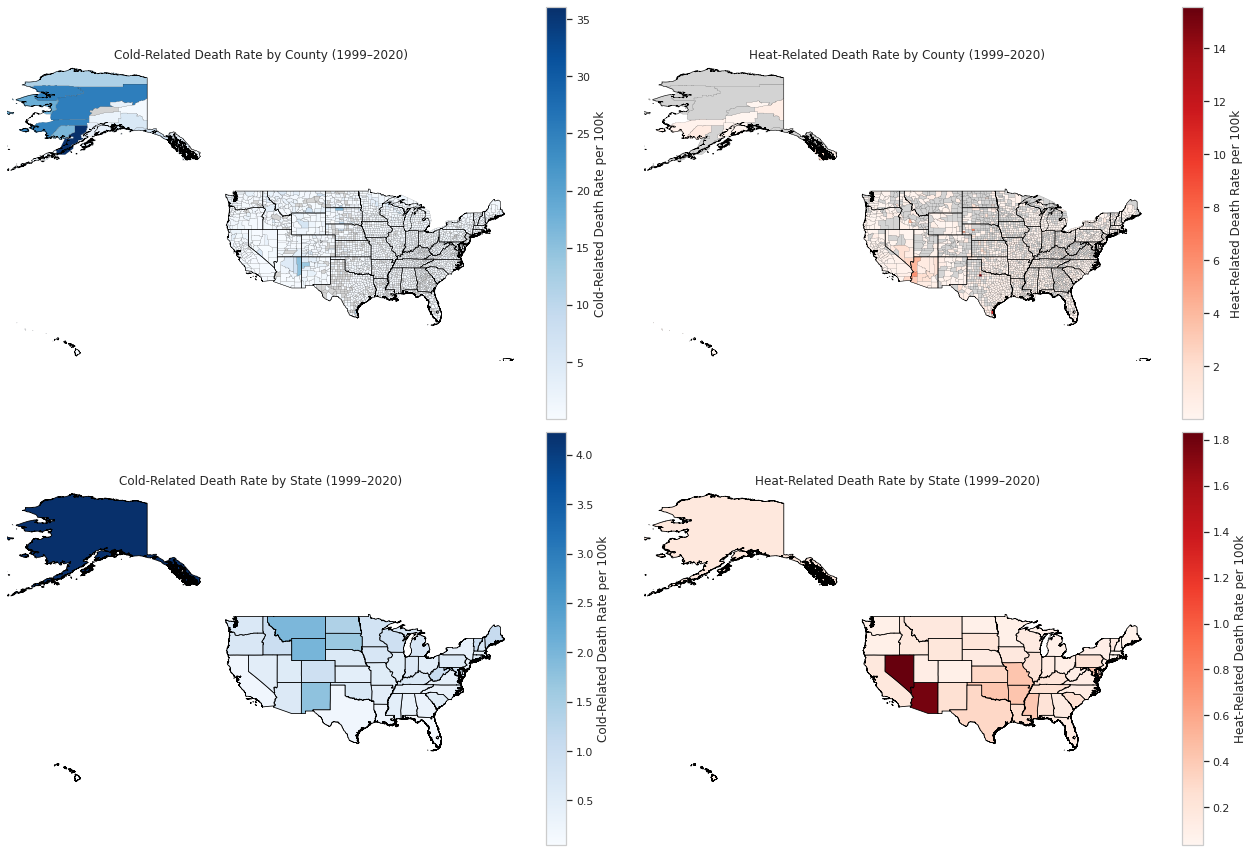

In [183]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# -------------------
# Top-left: Cold rate (county) with red outline for suppressed values
# -------------------
gdf_nonzero_cold = gdf_county[gdf_county['cold_rate'] != 0]
gdf_zero_cold = gdf_county[gdf_county['cold_rate'] == 0]

# Non-zero counties
gdf_nonzero_cold.plot(column='cold_rate', cmap='Blues', linewidth=0.1,
                      ax=axes[0, 0], edgecolor='black', legend=True,
                      legend_kwds={'label': "Cold-Related Death Rate per 100k"})

# Zero counties
gdf_zero_cold.plot(color='lightgray', linewidth=0.1, ax=axes[0, 0], edgecolor='black')

# State boundaries
gdf.boundary.plot(ax=axes[0, 0], color='black', linewidth=0.5)
axes[0, 0].set_title("Cold-Related Death Rate by County (1999–2020)")
axes[0, 0].axis('off')
axes[0, 0].set_xlim(-170, -65)
axes[0, 0].set_ylim(18, 72)

# -------------------
# Top-right: Heat rate (county) with red outline for suppressed values
# -------------------
gdf_nonzero_heat = gdf_county[gdf_county['heat_rate'] != 0]
gdf_zero_heat = gdf_county[gdf_county['heat_rate'] == 0]

# Non-zero counties
gdf_nonzero_heat.plot(column='heat_rate', cmap='Reds', linewidth=0.1,
                      ax=axes[0, 1], edgecolor='black', legend=True,
                      legend_kwds={'label': "Heat-Related Death Rate per 100k"})

# Zero counties
gdf_zero_heat.plot(color='lightgray', linewidth=0.1, ax=axes[0, 1], edgecolor='black')

# State boundaries
gdf.boundary.plot(ax=axes[0, 1], color='black', linewidth=0.5)
axes[0, 1].set_title("Heat-Related Death Rate by County (1999–2020)")
axes[0, 1].axis('off')
axes[0, 1].set_xlim(-170, -65)
axes[0, 1].set_ylim(18, 72)

# -------------------
# Bottom-left: Cold rate (state)
# -------------------
gdf.plot(column='cold_rate', cmap='Blues', linewidth=0.8, edgecolor='black',
         ax=axes[1, 0], legend=True,
         legend_kwds={'label': "Cold-Related Death Rate per 100k"})
axes[1, 0].set_title("Cold-Related Death Rate by State (1999–2020)")
axes[1, 0].axis('off')
axes[1, 0].set_xlim(-170, -65)
axes[1, 0].set_ylim(18, 72)

# -------------------
# Bottom-right: Heat rate (state)
# -------------------
gdf.plot(column='heat_rate', cmap='Reds', linewidth=0.8, edgecolor='black',
         ax=axes[1, 1], legend=True,
         legend_kwds={'label': "Heat-Related Death Rate per 100k"})
axes[1, 1].set_title("Heat-Related Death Rate by State (1999–2020)")
axes[1, 1].axis('off')
axes[1, 1].set_xlim(-170, -65)
axes[1, 1].set_ylim(18, 72)

plt.tight_layout()
plt.show()

## 2nd Revision

This is interesting to look at. However, the county rates are not entirely accurate since we replaced suppressed values with a 1. We did this because the CDC suppresses any row with a number of deaths less than or equal to 10, so we know at least one person died due to a temperature related death, but we are not sure how many.

For this reason we will likely have to stick with a "by state" analysis even though the county rate plots are much more detailed. We did similar processing to the first revision, but this time on a county level. This included formatting the tables again, merging the heat and cold deaths to a county shape file by the COUNTYFP and STATEFP. We also calculated the rates after replacing the suppressed values with 1, again this is why the map is not entirely accurate.

We then plotted all 4 maps just to compare how they look, this time zoomed in on the 50 states - ignoring overseas territories that were in our shapefile. Gray colored counties denote 0 deaths for temperature related deaths. One thing we could do for the county plot is to keep track of which values were originally suppressed and apply a pattern accross those counties to see how many are just estimates of the rate. We still need to tie in the number of days above or below a certain temperature threshold.

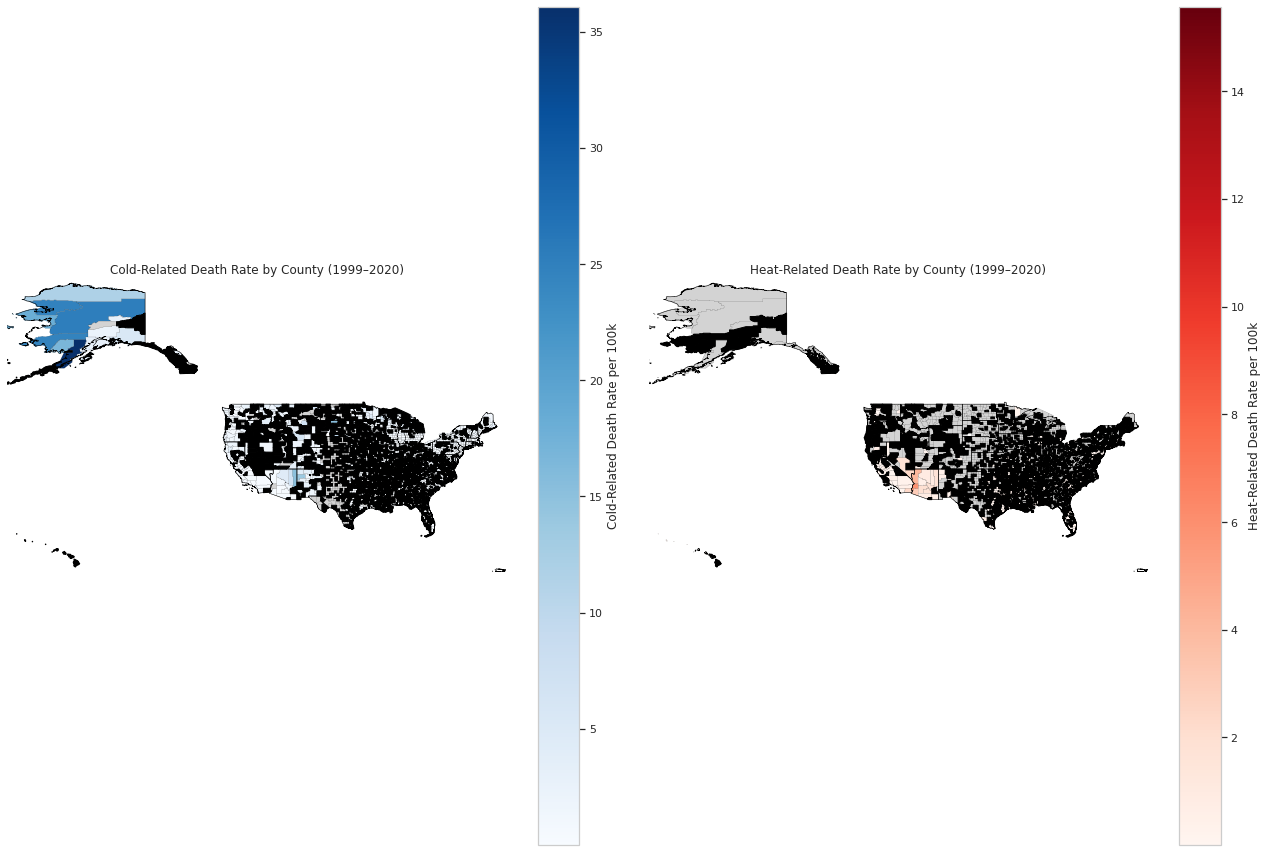

In [184]:
## Plot cold-related and heat-related deaths by county (supressed data in black)

fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# -------------------
# Top-left: Cold rate (county) w/ suppressed rates in black
gdf_nonzero_cold = gdf_county[gdf_county['cold_rate'] != 0]
gdf_zero_cold = gdf_county[gdf_county['cold_rate'] == 0]
gdf_suppressed_cold = gdf_county[gdf_county['Deaths_cold'] == 1]

# Non-zero counties
gdf_nonzero_cold.plot(column='cold_rate', cmap='Blues', linewidth=0.1,
                      ax=axes[0], edgecolor='black', legend=True,
                      legend_kwds={'label': "Cold-Related Death Rate per 100k"})

# Zero counties
gdf_zero_cold.plot(color='lightgray', linewidth=0.1, ax=axes[0], edgecolor='black')

# Suppressed counties in black
gdf_suppressed_cold.plot(color='black', edgecolor='black', linewidth=1.0, ax=axes[0])

# State boundaries
gdf.boundary.plot(ax=axes[0], color='black', linewidth=0.5)
axes[0].set_title("Cold-Related Death Rate by County (1999–2020)")
axes[0].axis('off')
axes[0].set_xlim(-170, -65)
axes[0].set_ylim(18, 72)

# -------------------
# Top-right: Heat rate (county) w/ suppressed rates in black
# -------------------
gdf_nonzero_heat = gdf_county[gdf_county['heat_rate'] != 0]
gdf_zero_heat = gdf_county[gdf_county['heat_rate'] == 0]
gdf_suppressed_heat = gdf_county[gdf_county['Deaths_heat'] == 1]

# Non-zero counties
gdf_nonzero_heat.plot(column='heat_rate', cmap='Reds', linewidth=0.1,
                      ax=axes[1], edgecolor='black', legend=True,
                      legend_kwds={'label': "Heat-Related Death Rate per 100k"})

# Zero counties
gdf_zero_heat.plot(color='lightgray', linewidth=0.1, ax=axes[1], edgecolor='black')

# Suppressed counties in black
gdf_suppressed_heat.plot(color='black', edgecolor='black', linewidth=1.0, ax=axes[1])

# State boundaries
gdf.boundary.plot(ax=axes[1], color='black', linewidth=0.5)
axes[1].set_title("Heat-Related Death Rate by County (1999–2020)")
axes[1].axis('off')
axes[1].set_xlim(-170, -65)
axes[1].set_ylim(18, 72)

plt.tight_layout()
plt.show()

_Note: This is more of a exploratory visual to see how many county death rates are suppressed (black). Obviously, most of them are. This is why we decided to stick to a state-level analysis to stay true to the data integrity._

In [185]:
weather = pd.read_csv("/home/jovyan/Project2/data/temp.csv")
weather.head()

,st_abb,st_code,date,stability,tmin,tmax,tavg
0,AL,1,19990101,stable,-1.561,13.796,6.117
1,AL,1,19990102,stable,0.906,14.459,7.682
2,AL,1,19990103,stable,-2.058,13.504,5.723
3,AL,1,19990104,stable,-7.689,1.720,-2.985
4,AL,1,19990105,stable,-10.850,-0.319,-5.584


In [186]:
counts = weather.groupby(['st_abb', 'st_code']).agg(
    hot_days=('tmax', lambda x: (x > 32).sum()),  # max temp in Celsius
    cold_days=('tmin', lambda x: (x < 0).sum())   # min temp in Celsius
).reset_index()

counts.head(20)

,st_abb,st_code,hot_days,cold_days
0,AL,1,1341,1046
1,AR,5,1270,1413
2,AZ,4,2088,1362
3,CA,6,1160,696
4,CO,8,82,4100
5,CT,9,133,2730
6,DC,11,696,1585
7,DE,10,463,1822
8,FL,12,1858,87
9,GA,13,1308,862


In [187]:
counts.rename(columns={"st_code":"FIPS"}, inplace=True)
counts['FIPS'] = counts['FIPS'].astype(str).str.zfill(2)
counts

,st_abb,FIPS,hot_days,cold_days
0,AL,01,1341,1046
1,AR,05,1270,1413
2,AZ,04,2088,1362
3,CA,06,1160,696
4,CO,08,82,4100
5,CT,09,133,2730
6,DC,11,696,1585
7,DE,10,463,1822
8,FL,12,1858,87
9,GA,13,1308,862


In [188]:
gdf = gpd.read_file("/home/jovyan/Project2/data/intermediary/merged_death_rates.shp")
gdf.head()

,STATE,NAME,FIPS,LON,LAT,State_1,Heat Death,Cold Death,Population,cold_rate,heat_rate,geometry
0,AL,Alabama,01,-86.82676,32.79354,Alabama,238.0,388.0,103604166.0,0.374502,0.229720,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ..."
1,AR,Arkansas,05,-92.43920,34.89977,Arkansas,271.0,319.0,63181817.0,0.504892,0.428921,"POLYGON ((-91.62986 36.49921, -91.62849 36.499..."
2,AS,American Samoa,60,-170.37215,-14.26486,None,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((-168.14924 -14.53377, -168.148..."
3,AZ,Arizona,04,-111.66457,34.29323,Arizona,2462.0,864.0,138079425.0,0.625727,1.783032,"POLYGON ((-110.49090 37.00361, -110.48750 37.0..."
4,CA,California,06,-119.60818,37.24537,California,1481.0,1743.0,815706063.0,0.213680,0.181560,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263..."


In [189]:
print(gdf["FIPS"].dtype)
print(counts["FIPS"].dtype)

object
object


In [190]:
gdf = gdf.merge(counts, on="FIPS", how="left")
gdf = gdf[gdf['FIPS'].isin(state_fps_50)] # only the 50 states
gdf.columns.to_list()

['STATE',
 'NAME',
 'FIPS',
 'LON',
 'LAT',
 'State_1',
 'Heat Death',
 'Cold Death',
 'Population',
 'cold_rate',
 'heat_rate',
 'geometry',
 'st_abb',
 'hot_days',
 'cold_days']

In [191]:
gdf=gdf.drop(columns=["st_abb", "State_1"])

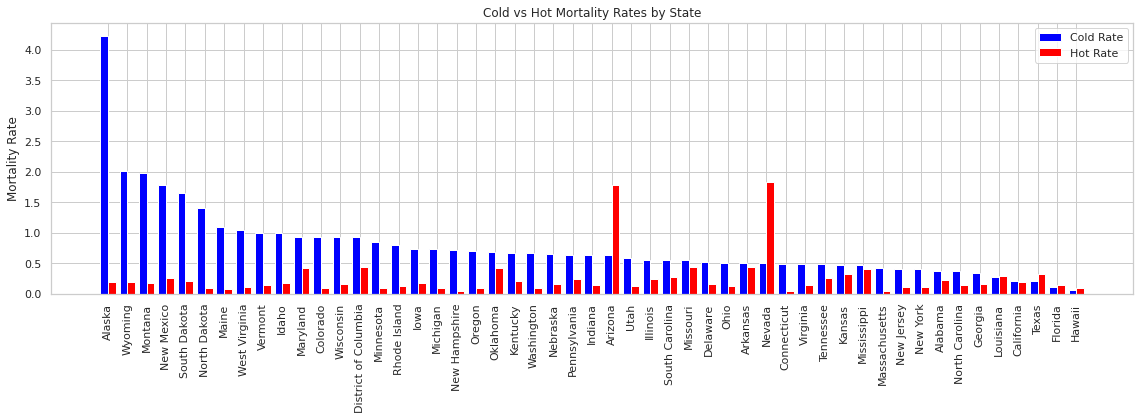

In [192]:
# Sort by cold mortality rate
gdf_sorted = gdf.sort_values('cold_rate', ascending=False)

states = gdf_sorted['NAME']
x = np.arange(len(states))

fig, ax = plt.subplots(figsize=(16,6))

width = 0.4

ax.bar(x - width/2, gdf_sorted['cold_rate'], width, label='Cold Rate', color='blue')
ax.bar(x + width/2, gdf_sorted['heat_rate'], width, label='Hot Rate', color='red')

ax.set_xticks(x)
ax.set_xticklabels(states, rotation=90)
ax.set_ylabel("Mortality Rate")
ax.set_title("Cold vs Hot Mortality Rates by State")
ax.legend()

plt.tight_layout()
plt.show()

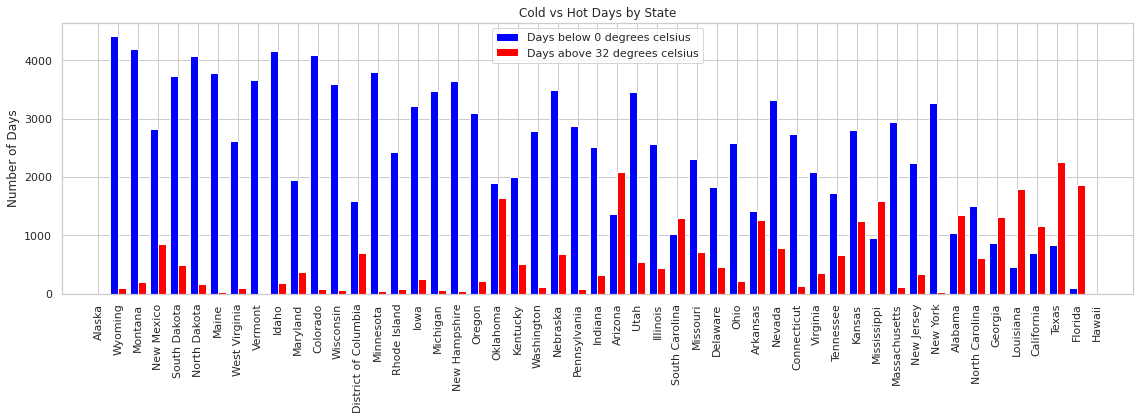

In [193]:
# Sort by cold moratility rate
gdf_sorted = gdf.sort_values('cold_rate', ascending=False)

states = gdf_sorted['NAME']
x = np.arange(len(states))

fig, ax = plt.subplots(figsize=(16,6))

width = 0.4

ax.bar(x - width/2, gdf_sorted['cold_days'], width, label='Days below 0 degrees celsius', color='blue')
ax.bar(x + width/2, gdf_sorted['hot_days'], width, label='Days above 32 degrees celsius', color='red')

ax.set_xticks(x)
ax.set_xticklabels(states, rotation=90)
ax.set_ylabel("Number of Days")
ax.set_title("Cold vs Hot Days by State")
ax.legend()

plt.tight_layout()
plt.show()

In [194]:
gdf["death_rate_diff"] = gdf["cold_rate"]-gdf['heat_rate'] # difference between cold and heat rate, negative values mean higher heat rate positive mean higher cold rate
gdf.head()

,STATE,NAME,FIPS,LON,LAT,Heat Death,Cold Death,Population,cold_rate,heat_rate,geometry,hot_days,cold_days,death_rate_diff
0,AL,Alabama,01,-86.82676,32.79354,238.0,388.0,103604166.0,0.374502,0.229720,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ...",1341.0,1046.0,0.144782
1,AR,Arkansas,05,-92.43920,34.89977,271.0,319.0,63181817.0,0.504892,0.428921,"POLYGON ((-91.62986 36.49921, -91.62849 36.499...",1270.0,1413.0,0.075971
3,AZ,Arizona,04,-111.66457,34.29323,2462.0,864.0,138079425.0,0.625727,1.783032,"POLYGON ((-110.49090 37.00361, -110.48750 37.0...",2088.0,1362.0,-1.157305
4,CA,California,06,-119.60818,37.24537,1481.0,1743.0,815706063.0,0.213680,0.181560,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263...",1160.0,696.0,0.032119
5,CO,Colorado,08,-105.54783,38.99855,106.0,1023.0,110389320.0,0.926720,0.096024,"POLYGON ((-106.87560 41.00301, -106.85850 41.0...",82.0,4100.0,0.830696


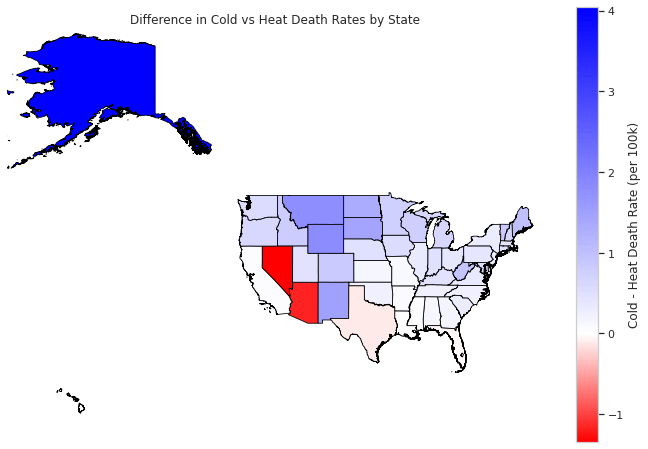

In [195]:
# Create a Normalize object centered at 0
norm = colors.TwoSlopeNorm(vmin=gdf['death_rate_diff'].min(),
                           vcenter=0,
                           vmax=gdf['death_rate_diff'].max())

fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(
    column='death_rate_diff',
    cmap='bwr_r',   # reversed blue-white-red: positive = blue, negative = red
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Cold - Heat Death Rate (per 100k)"},
    ax=ax,
    norm=norm       # center color scale at 0
)

ax.set_title("Difference in Cold vs Heat Death Rates by State")
ax.axis('off')
ax.set_xlim(-170, -65)
ax.set_ylim(18, 72)
plt.show()

## 3rd Revision

These plots look a lot better. This choropleth gives us an idea of which states have a higher death rate due to cold related deaths versus heat related deaths.

To get this value we took the difference between the cold death rate and the heat death rate. Values that are positive show a higher death rate from cold, and values that are negative show a higher death rate from heat.

There certainly seems to be more blue colored states which means that per 100,000 people there is a higher rate of deaths due to cold temperatures. The bar graphs are mostly supplemental, but they show heat-related versus cold-related mortality rates for each state and the number of days where the minimum temperature in the state was below 0°C (32°F) or where the maximum temperature was above 32°C (89.6°F).

From the first bar graph we can see that a few states have much higher mortality rates due to heat, such as Arizona or Texas, but the cold related mortality rates seem to be more consistent across the states.

From the second bar graph we can see that most of the states have a higher amount of days below freezing.

**Critique:** We still need to add a border to the map and a cartographer's block. It may be worth while to do an inset for Alaska and possibly Hawaii to allow us to zoom in on the map even more. It may also be interesting to look at poverty values for each of the states and see if there is a relationship between the amount of deaths and poverty rate.

In [196]:
file_path = "/home/jovyan/Project2/data/poverty_rate.xlsx"

# Row numbers where each table's header starts
header_rows = [5, 58, 111, 164, 217, 270, 323, 376, 429, 482,
               535, 588, 641, 694, 747, 800, 853, 906, 959,
               1012, 1065, 1118, 1171, 1224, 1277, 1330, 1383,
               1436, 1489, 1542, 1595, 1648, 1701, 1754, 1807,
               1860, 1913, 1966, 2019, 2072, 2125, 2178, 2231,
               2284, 2337, 2390, 2443]

# Number of rows per table (≈ 53 states + 1 header)
nrows = 54

# Store tables
tables = []

for i, start_row in enumerate(header_rows):
    # Read each table
    df = pd.read_excel(file_path, skiprows=start_row - 1, nrows=nrows)
    
    # Skip if not a valid table
    if df.empty or "State" not in df.columns[0]:
        continue

    # Clean columns
    df.columns = [
        "State", "Total_population", "Number_in_poverty",
        "MOE_population", "Percent_in_poverty", "MOE_percent"
    ]

    # Get year (usually the row before the header)
    year_cell = pd.read_excel(file_path, skiprows=start_row - 3, nrows=1).iloc[0, 0]
    year_match = re.search(r'(\d{4})', str(year_cell))
    if year_match:
        year = int(year_match.group(1))
    else:
        continue


    df["Year"] = year
    tables.append(df)

# Combine all tables
poverty_all = pd.concat(tables, ignore_index=True)

# Filter to 1999–2020
poverty_filtered = poverty_all[(poverty_all["Year"] >= 1999) & (poverty_all["Year"] <= 2020)]

In [197]:
poverty_filtered = poverty_filtered.copy()
poverty_filtered['Year'] = poverty_filtered['Year'].astype(str).str.extract(r'(\d{4})')[0].astype(int)


# filter for 1999–2020, these numbers are in thousands
poverty_filtered = poverty_filtered.query('1999 <= Year <= 2020')
poverty_filtered = poverty_filtered[~poverty_filtered['State'].str.match(r'^\d{4}')]
poverty_filtered.head()

,State,Total_population,Number_in_poverty,MOE_population,Percent_in_poverty,MOE_percent,Year
216,Alabama,5001,744,139,14.9,2.8,2020
217,Alaska,708,95,16,13.4,2.2,2020
218,Arizona,7203,783,122,10.9,1.7,2020
219,Arkansas,2974,420,56,14.1,1.8,2020
220,California,39200,4332,302,11.1,0.8,2020


In [198]:
# poverty_filtered["Total_population"] = pd.to_numeric(
#     poverty_filtered["Total_population"], errors="coerce"
# )
# poverty_filtered["Number_in_poverty"] = pd.to_numeric(
#     poverty_filtered["Number_in_poverty"], errors="coerce"
# )
poverty_filtered["Percent_in_poverty"] = pd.to_numeric(poverty_filtered["Percent_in_poverty"], errors="coerce")
poverty_filtered.head(10)


,State,Total_population,Number_in_poverty,MOE_population,Percent_in_poverty,MOE_percent,Year
216,Alabama,5001,744,139,14.9,2.8,2020
217,Alaska,708,95,16,13.4,2.2,2020
218,Arizona,7203,783,122,10.9,1.7,2020
219,Arkansas,2974,420,56,14.1,1.8,2020
220,California,39200,4332,302,11.1,0.8,2020
221,Colorado,5717,546,144,9.5,2.5,2020
222,Connecticut,3545,396,80,11.2,2.3,2020
223,Delaware,991,104,22,10.5,2.2,2020
224,District of Columbia,680,114,14,16.8,2,2020
225,Florida,21510,2854,267,13.3,1.2,2020


In [199]:
state_totals = (
    poverty_filtered.groupby("State")["Percent_in_poverty"]
    .mean()
    .reset_index(name="Poverty_percent")
)

In [200]:
state_totals.head()

,State,Poverty_percent
0,Alabama,15.641667
1,Alaska,10.387500
2,Arizona,15.454167
3,Arkansas,16.275000
4,California,13.625000


In [201]:
state_totals = state_totals.rename(columns={'State': 'NAME'})
state_totals['NAME'] = state_totals['NAME'].str.strip().str.upper()
gdf['NAME'] = gdf['NAME'].str.strip().str.upper()

In [202]:
# Merge into gdf
gdf = gdf.merge(state_totals[['NAME','Poverty_percent']], 
                on='NAME', 
                how='left')

In [203]:
gdf.head()

,STATE,NAME,FIPS,LON,LAT,Heat Death,Cold Death,Population,cold_rate,heat_rate,geometry,hot_days,cold_days,death_rate_diff,Poverty_percent
0,AL,ALABAMA,01,-86.82676,32.79354,238.0,388.0,103604166.0,0.374502,0.229720,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ...",1341.0,1046.0,0.144782,15.641667
1,AR,ARKANSAS,05,-92.43920,34.89977,271.0,319.0,63181817.0,0.504892,0.428921,"POLYGON ((-91.62986 36.49921, -91.62849 36.499...",1270.0,1413.0,0.075971,16.275000
2,AZ,ARIZONA,04,-111.66457,34.29323,2462.0,864.0,138079425.0,0.625727,1.783032,"POLYGON ((-110.49090 37.00361, -110.48750 37.0...",2088.0,1362.0,-1.157305,15.454167
3,CA,CALIFORNIA,06,-119.60818,37.24537,1481.0,1743.0,815706063.0,0.213680,0.181560,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263...",1160.0,696.0,0.032119,13.625000
4,CO,COLORADO,08,-105.54783,38.99855,106.0,1023.0,110389320.0,0.926720,0.096024,"POLYGON ((-106.87560 41.00301, -106.85850 41.0...",82.0,4100.0,0.830696,10.191667


In [204]:
gdf.to_file("/home/jovyan/Project2/data/final_file.shp")

/tmp/ipykernel_142/3103222210.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("/home/jovyan/Project2/data/final_file.shp")


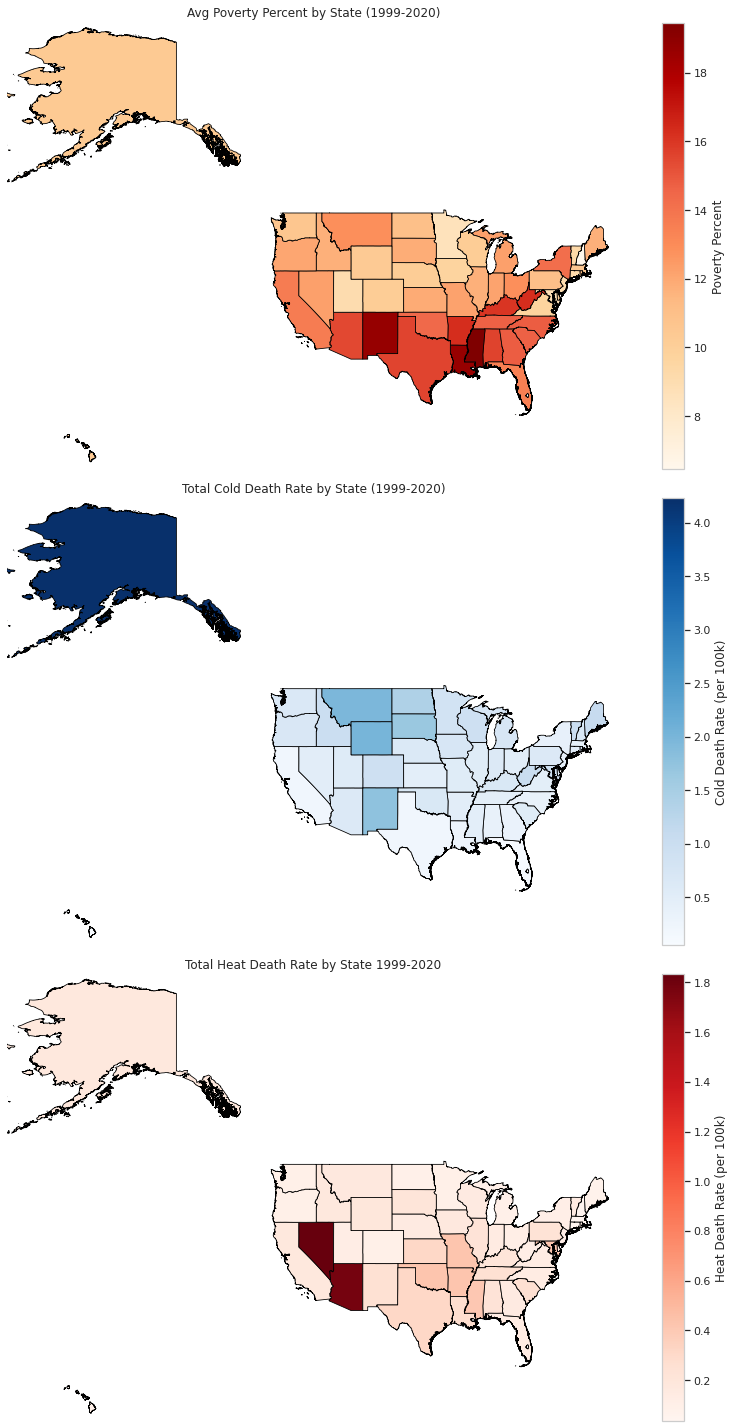

In [206]:
fig, axes = plt.subplots(3, 1, figsize=(12, 20))  # 3 rows, 1 column

# 1. Poverty Percent
norm_pov = colors.Normalize(vmin=gdf['Poverty_percent'].min(),
                            vmax=gdf['Poverty_percent'].max())

gdf.plot(
    column='Poverty_percent',
    cmap='OrRd',
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Poverty Percent"},
    ax=axes[0],
    norm=norm_pov
)
axes[0].set_title("Avg Poverty Percent by State (1999-2020)")
axes[0].axis('off')
axes[0].set_xlim(-170, -65)
axes[0].set_ylim(18, 72)

# 2. Cold Death Rate
norm_cold = colors.Normalize(vmin=gdf['cold_rate'].min(),
                             vmax=gdf['cold_rate'].max())

gdf.plot(
    column='cold_rate',
    cmap='Blues',
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Cold Death Rate (per 100k)"},
    ax=axes[1],
    norm=norm_cold
)
axes[1].set_title("Total Cold Death Rate by State (1999-2020)")
axes[1].axis('off')
axes[1].set_xlim(-170, -65)
axes[1].set_ylim(18, 72)

# 3. Heat Death Rate
norm_heat = colors.Normalize(vmin=gdf['heat_rate'].min(),
                             vmax=gdf['heat_rate'].max())

gdf.plot(
    column='heat_rate',
    cmap='Reds',
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Heat Death Rate (per 100k)"},
    ax=axes[2],
    norm=norm_heat
)
axes[2].set_title("Total Heat Death Rate by State 1999-2020")
axes[2].axis('off')
axes[2].set_xlim(-170, -65)
axes[2].set_ylim(18, 72)

plt.tight_layout()
plt.show()

## 4th Revision 

We have now tied in poverty to a choropleth, but not sure this shows us much. It might look better as a scatter plot showing cold deaths and heat deaths - to see if there is a relationship or not. This data was given in an Excel file with different tables for each year, so we had to concatenate multiple tables from each sheet to put them into one DataFrame and then filtered that for the years that we wanted. We then summed the population and people in poverty counts for each state and merged this table with our GeoDataFrame from earlier to get all our data into on GeoDataFrame.

At this point we have done most of the calculations we can. For the final revision, we think it would be best to have the (1) choropleth with differences in death rates, (2) a bar charts comparing cold days versus hot days, (3) another bar chart comparing cold and heat related mortality rates, (4) and a scatter plot of the poverty percentage vs total deaths for each state.

**Critique:** We realized that we have not tansformed the crs. We will convert this to EPSG:5070 to keep the states in reasonable proportions. We will fine tune each of these plots for the final visuals.

In [186]:
gdf = gpd.read_file("/home/jovyan/Project2/data/final_file.shp")

In [187]:
gdf.head()

,STATE,NAME,FIPS,LON,LAT,Heat Death,Cold Death,Population,cold_rate,heat_rate,hot_days,cold_days,death_rate,Poverty_pe,geometry
0,AL,ALABAMA,01,-86.82676,32.79354,238.0,388.0,103604166.0,0.374502,0.229720,1341.0,1046.0,0.144782,15.641667,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ..."
1,AR,ARKANSAS,05,-92.43920,34.89977,271.0,319.0,63181817.0,0.504892,0.428921,1270.0,1413.0,0.075971,16.275000,"POLYGON ((-91.62986 36.49921, -91.62849 36.499..."
2,AZ,ARIZONA,04,-111.66457,34.29323,2462.0,864.0,138079425.0,0.625727,1.783032,2088.0,1362.0,-1.157305,15.454167,"POLYGON ((-110.49090 37.00361, -110.48750 37.0..."
3,CA,CALIFORNIA,06,-119.60818,37.24537,1481.0,1743.0,815706063.0,0.213680,0.181560,1160.0,696.0,0.032119,13.625000,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263..."
4,CO,COLORADO,08,-105.54783,38.99855,106.0,1023.0,110389320.0,0.926720,0.096024,82.0,4100.0,0.830696,10.191667,"POLYGON ((-106.87560 41.00301, -106.85850 41.0..."


In [188]:
corr = gdf['death_rate'].corr(gdf['Poverty_pe'])
print(f"Correlation between poverty percent and death rate difference: {corr:.3f}")

Correlation between poverty percent and death rate difference: -0.233


In [189]:
corr = gdf['cold_rate'].corr(gdf['Poverty_pe'])
print(f"Correlation between poverty percent and cold death rate difference: {corr:.3f}")

Correlation between poverty percent and cold death rate difference: -0.136


In [190]:
corr = gdf['heat_rate'].corr(gdf['Poverty_pe'])
print(f"Correlation between poverty percent and heat death rate difference: {corr:.3f}")

Correlation between poverty percent and heat death rate difference: 0.260


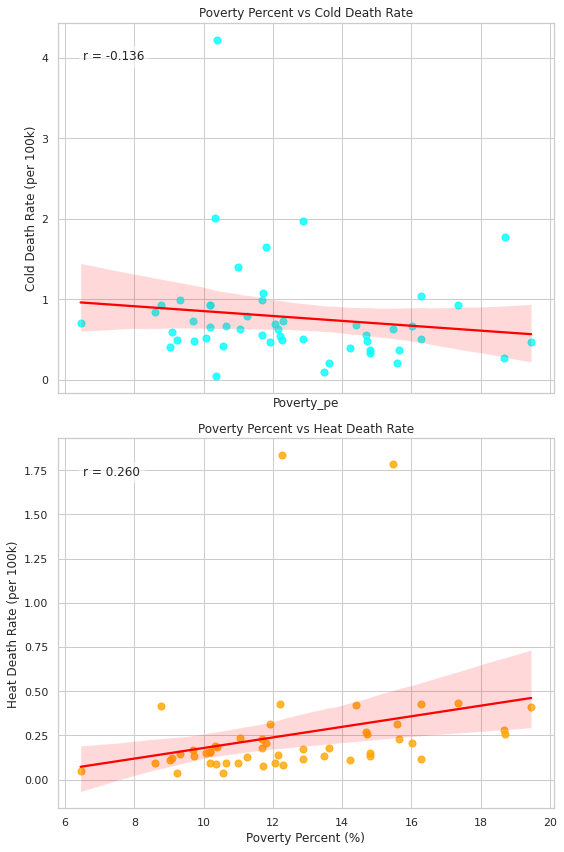

In [191]:
# Set style
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

# Cold death rate
sns.regplot(
    x='Poverty_pe', 
    y='cold_rate', 
    data=gdf,
    ax=axes[0],
    scatter_kws={'s':50, 'color':'cyan'},
    line_kws={'color':'red'}
)
axes[0].set_title("Poverty Percent vs Cold Death Rate")
axes[0].set_ylabel("Cold Death Rate (per 100k)")
# Calculate correlation
corr_cold = gdf['cold_rate'].corr(gdf['Poverty_pe'])
axes[0].text(
    0.05, 0.9, f'r = {corr_cold:.3f}', 
    transform=axes[0].transAxes, 
    fontsize=12, 
    bbox=dict(facecolor='white', alpha=0.5)
)

# Heat death rate
sns.regplot(
    x='Poverty_pe', 
    y='heat_rate', 
    data=gdf,
    ax=axes[1],
    scatter_kws={'s':50, 'color':'orange'},
    line_kws={'color':'red'}
)
axes[1].set_title("Poverty Percent vs Heat Death Rate")
axes[1].set_xlabel("Poverty Percent (%)")
axes[1].set_ylabel("Heat Death Rate (per 100k)")
# Calculate correlation
corr_heat = gdf['heat_rate'].corr(gdf['Poverty_pe'])
axes[1].text(
    0.05, 0.9, f'r = {corr_heat:.3f}', 
    transform=axes[1].transAxes, 
    fontsize=12, 
    bbox=dict(facecolor='white', alpha=0.5)
)

plt.tight_layout()
plt.show()




**Interesting Insight:** There seems to be a positive correlation between poverty percent and heat death rates but a negative correlation between cold death rates and poverty percent. Maybe people who live in poverty don't have as much access to air conditioning, but are able to access heat?

In [195]:
# Create spatial weights based on contiguity (neighboring states)
w = libpysal.weights.Queen.from_dataframe(gdf)
w.transform = 'r'  # row-standardize

# Compute Moran’s I for death rate difference
moran_death = Moran(gdf['death_rate'], w)
print(f"Moran's I for death_rate_diff: {moran_death.I:.3f}, p-value: {moran_death.p_sim:.4f}")
# Compute Moran's I for cold rate
moran_death = Moran(gdf['cold_rate'], w)
print(f"Moran's I for cold_rate: {moran_death.I:.3f}, p-value: {moran_death.p_sim:.4f}")
# Compute Moran’s I for heat rate
moran_death = Moran(gdf['heat_rate'], w)
print(f"Moran's I for heat_rate: {moran_death.I:.3f}, p-value: {moran_death.p_sim:.4f}")

('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
Moran's I for death_rate_diff: 0.218, p-value: 0.0100
Moran's I for cold_rate: 0.193, p-value: 0.0200
Moran's I for heat_rate: 0.172, p-value: 0.0340


**Moran's I Analysis:** We ran Moran's I analysis on the death rate difference (cold-hot), cold death rate, and heat death rate to check and see if neighbors nearby have similar values. Moran's I was positive for all three which tells us that each value for the states are clustered near eachother. Also, the p-value was less than 0.05 which means the clustering is not random.

In [196]:
gdf = gdf.to_crs("EPSG:5070")
gdf.head()

,STATE,NAME,FIPS,LON,LAT,Heat Death,Cold Death,Population,cold_rate,heat_rate,hot_days,cold_days,death_rate,Poverty_pe,geometry
0,AL,ALABAMA,01,-86.82676,32.79354,238.0,388.0,103604166.0,0.374502,0.229720,1341.0,1046.0,0.144782,15.641667,"MULTIPOLYGON (((757193.013 829564.839, 757562...."
1,AR,ARKANSAS,05,-92.43920,34.89977,271.0,319.0,63181817.0,0.504892,0.428921,1270.0,1413.0,0.075971,16.275000,"POLYGON ((387717.031 1503566.564, 387838.480 1..."
2,AZ,ARIZONA,04,-111.66457,34.29323,2462.0,864.0,138079425.0,0.625727,1.783032,2088.0,1362.0,-1.157305,15.454167,"POLYGON ((-1272519.464 1648367.829, -1272239.9..."
3,CA,CALIFORNIA,06,-119.60818,37.24537,1481.0,1743.0,815706063.0,0.213680,0.181560,1160.0,696.0,0.032119,13.625000,"MULTIPOLYGON (((-2068648.575 1326168.145, -206..."
4,CO,COLORADO,08,-105.54783,38.99855,106.0,1023.0,110389320.0,0.926720,0.096024,82.0,4100.0,0.830696,10.191667,"POLYGON ((-905484.580 2051196.799, -904073.656..."


In [197]:
gdf.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# Final Visuals (before prototype/development)

## Hypothesis Restated:
### Across the United States, mortality rates associated with cold weather are higher than mortality rates associated with hot weather.

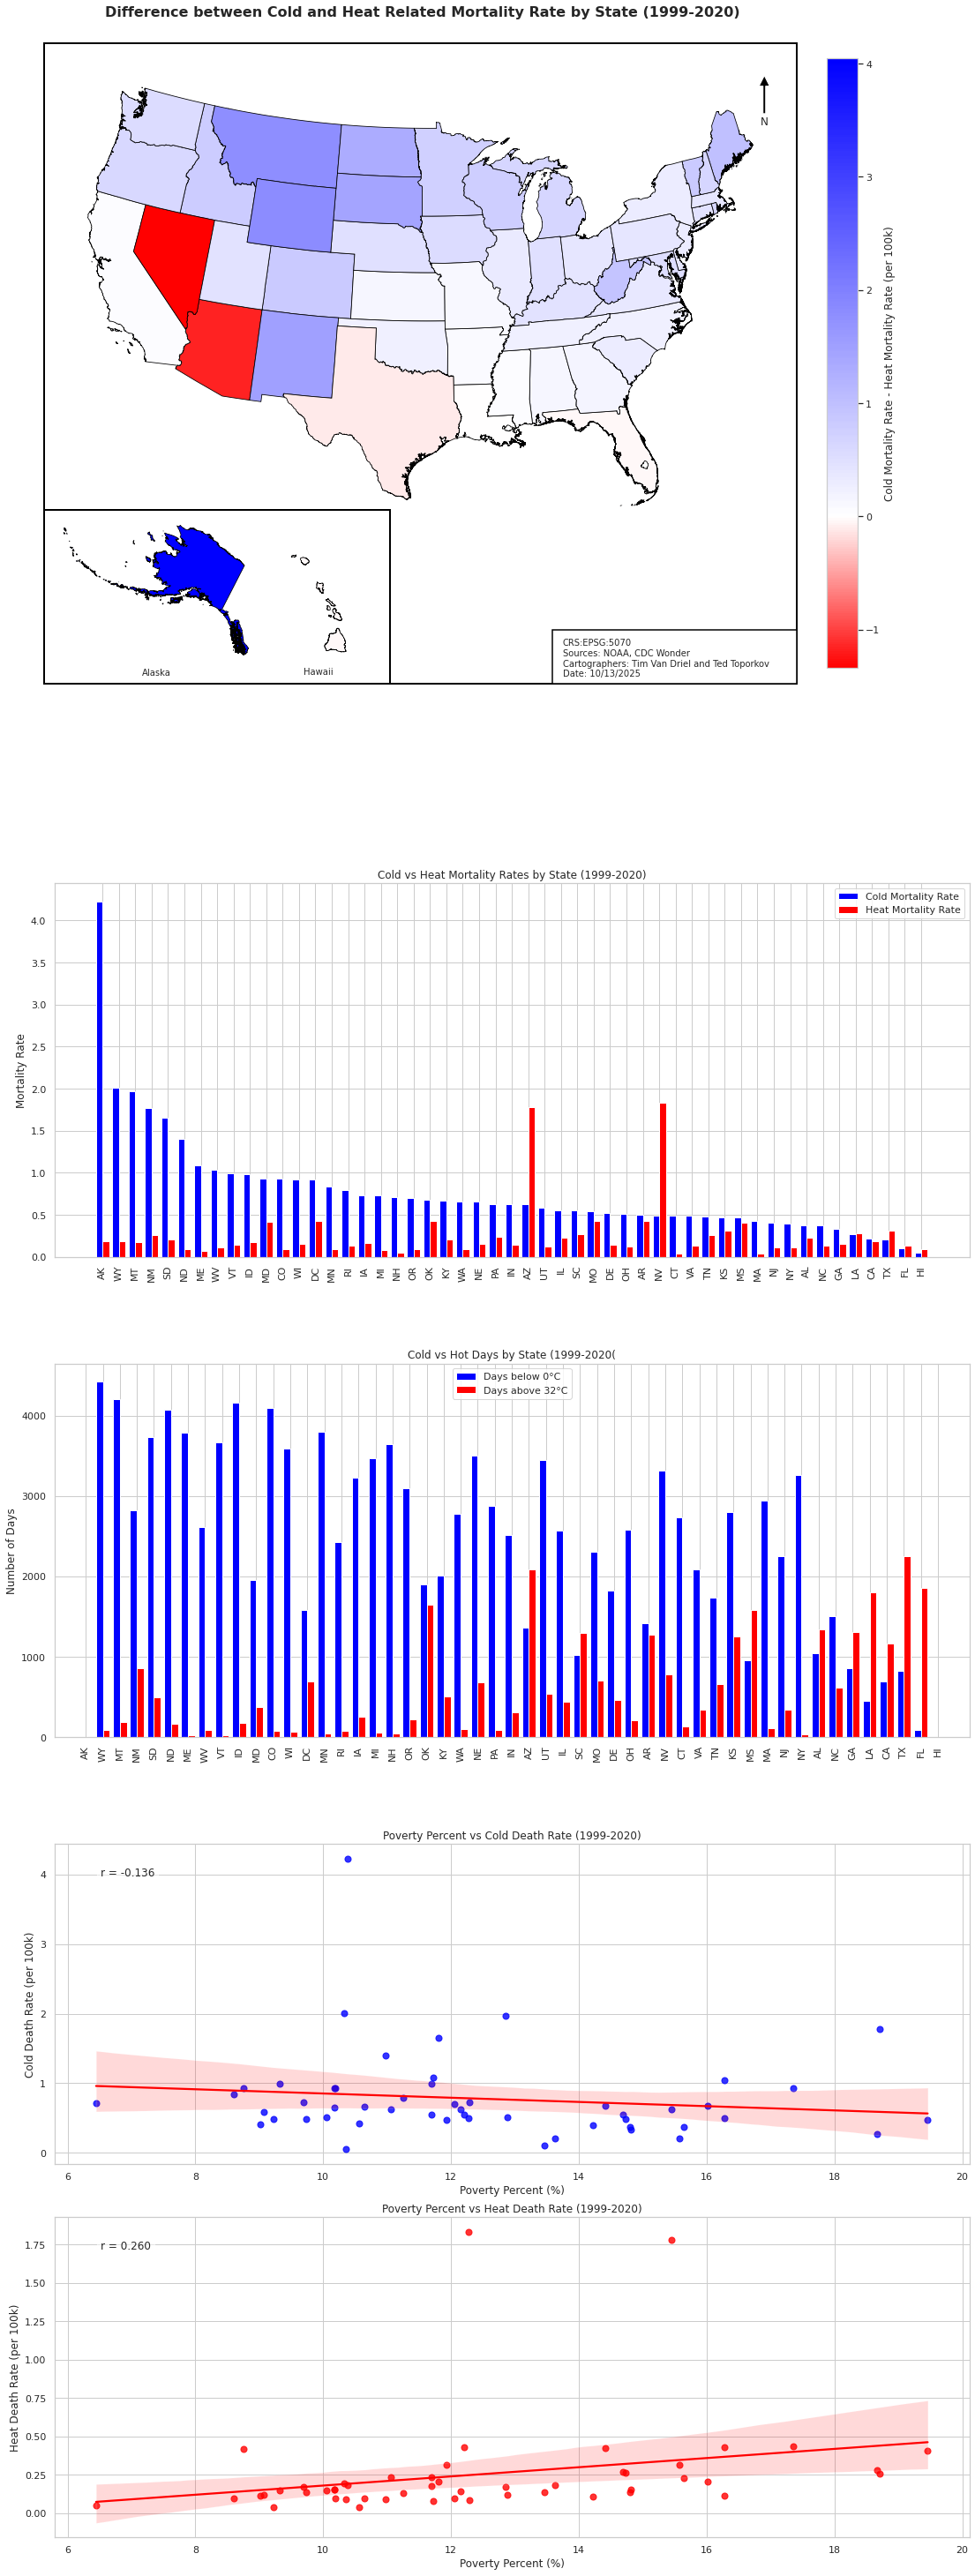

In [198]:
# Separate contiguous US, Alaska, Hawaii for insets
contig = gdf[~gdf['FIPS'].isin(['02', '15'])]  # exclude Alaska (02) and Hawaii (15)
alaska = gdf[gdf['FIPS'] == '02']
hawaii = gdf[gdf['FIPS'] == '15']

# Create figure
fig = plt.figure(figsize=(16, 42))  # taller figure

# -----------------------------
# 1️⃣ Death Rate Choropleth
# -----------------------------
ax_main = fig.add_axes([0.05, 0.75, 0.9, 0.22])
norm = colors.TwoSlopeNorm(vmin=gdf['death_rate'].min(),
                           vcenter=0,
                           vmax=gdf['death_rate'].max())
plot = contig.plot(
    column='death_rate', 
    cmap='bwr_r', 
    linewidth=0.8, 
    edgecolor='black', 
    legend=True,
    legend_kwds={'label': "Cold Mortality Rate - Heat Mortality Rate (per 100k)"},
    ax=ax_main,
    norm=norm
)
ax_main.axis('off')

# Move the colorbar manually
cbar = plot.get_figure().axes[-1]  # the colorbar is usually the last axes
cbar.set_position([0.81, 0.715, 0.03, 0.24])  # [left, bottom, width, height] in figure coords

# Move the title above the rectangle
fig.text(
    0.1, 0.965, 
    "Difference between Cold and Heat Related Mortality Rate by State (1999-2020)", 
    fontsize=16, 
    fontweight='bold',
    ha='left'
)

ax_main.axis('off')

# Alaska inset
ax_ak = fig.add_axes([0.05, 0.69, 0.2, 0.12])
alaska.plot(column='death_rate', cmap='bwr_r', linewidth=0.8, edgecolor='black', ax=ax_ak, norm=norm)
ax_ak.axis('off')
# Label at the bottom
ax_ak.text(
    0.5, -0.05, "Alaska", 
    ha='center', va='top', fontsize=10, transform=ax_ak.transAxes
)

# Hawaii inset (moved slightly up)
ax_hi = fig.add_axes([0.28, 0.725, 0.06, 0.04])
hawaii.plot(column='death_rate', cmap='bwr_r', linewidth=0.8, edgecolor='black', ax=ax_hi, norm=norm)
ax_hi.axis('off')
# Label at the bottom
ax_hi.text(
    0.5, -0.1, "Hawaii", 
    ha='center', va='top', fontsize=10, transform=ax_hi.transAxes
)

# Rectangle around both insets, aligned with main map rectangle
rect_insets = patches.Rectangle(
    (0.04, 0.715),  # lower-left corner slightly above bottom of main rectangle
    0.34,           # width to cover both Alaska + Hawaii
    0.065,           # height to fit insets nicely
    linewidth=2,
    edgecolor='black',
    facecolor='none',
    transform=fig.transFigure
)
fig.patches.append(rect_insets)

# Main rectangle around map + insets (unchanged)
rect = patches.FancyBboxPatch(
    (0.04, 0.715),   # lower-left corner
    0.74,            # width
    0.24,            # height
    boxstyle="square,pad=0",
    fill=False,
    linewidth=2,
    edgecolor='black',
    transform=fig.transFigure
)
fig.patches.append(rect)

# North arrow
ax_main.annotate(
    'N', 
    xy=(0.97, 0.98),     # tip of the arrow
    xytext=(0.97, 0.88), # tail of the arrow
    arrowprops=dict(facecolor='black', width=3, headwidth=12),
    ha='center', 
    va='center', 
    fontsize=12,
    xycoords='axes fraction'
)
# Add text inside the rectangle
info_text = (
    "CRS:EPSG:5070\n"
    "Sources: NOAA, CDC Wonder\n"
    "Cartographers: Tim Van Driel and Ted Toporkov\n"
    "Date: 10/13/2025"
)

rect_info = patches.Rectangle(
    (0.54, 0.715),  # slightly above bottom of figure
    0.24,
    0.02,
    linewidth=1.5,
    edgecolor='black',
    facecolor='white',
    transform=fig.transFigure
)
fig.patches.append(rect_info)

fig.text(
    0.55, 0.717,  # slightly inside rectangle
    info_text,
    fontsize=10,
    va='bottom',
    ha='left'
)

# -----------------------------
# 2️⃣ Cold vs Hot Deaths by State
# -----------------------------
ax2 = fig.add_axes([0.05, 0.50, 0.9, 0.14])
gdf_sorted = gdf.sort_values('cold_rate', ascending=False)
states = gdf_sorted['STATE'] 
x = np.arange(len(states))
width = 0.4
ax2.bar(x - width/2, gdf_sorted['cold_rate'], width, label='Cold Mortality Rate', color='blue')
ax2.bar(x + width/2, gdf_sorted['heat_rate'], width, label='Heat Mortality Rate', color='red')
ax2.set_xticks(x)
ax2.set_xticklabels(states, rotation=90)
ax2.set_ylabel("Mortality Rate")
ax2.set_title("Cold vs Heat Mortality Rates by State (1999-2020)")
ax2.legend()

# -----------------------------
# 3️⃣ Cold vs Hot Days by State
# -----------------------------
ax3 = fig.add_axes([0.05, 0.32, 0.9, 0.14])
ax3.bar(x - width/2, gdf_sorted['cold_days'], width, label='Days below 0°C', color='blue')
ax3.bar(x + width/2, gdf_sorted['hot_days'], width, label='Days above 32°C', color='red')
ax3.set_xticks(x)
ax3.set_xticklabels(states, rotation=90)
ax3.set_ylabel("Number of Days")
ax3.set_title("Cold vs Hot Days by State (1999-2020(")
ax3.legend()

# -----------------------------
# 4️⃣ Poverty Percent vs Cold Death Rate
# -----------------------------
ax4 = fig.add_axes([0.05, 0.16, 0.9, 0.12])
sns.regplot(
    x='Poverty_pe',
    y='cold_rate',
    data=gdf,
    ax=ax4,
    scatter_kws={'s':50, 'color':'blue'},
    line_kws={'color':'red'}
)
ax4.set_title("Poverty Percent vs Cold Death Rate (1999-2020)")
ax4.set_ylabel("Cold Death Rate (per 100k)")
ax4.set_xlabel("Poverty Percent (%)")
corr_cold = gdf['cold_rate'].corr(gdf['Poverty_pe'])
ax4.text(0.05, 0.9, f'r = {corr_cold:.3f}', transform=ax4.transAxes,
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# -----------------------------
# 5️⃣ Poverty Percent vs Heat Death Rate
# -----------------------------
ax5 = fig.add_axes([0.05, 0.02, 0.9, 0.12])
sns.regplot(
    x='Poverty_pe',
    y='heat_rate',
    data=gdf,
    ax=ax5,
    scatter_kws={'s':50, 'color':'red'},
    line_kws={'color':'red'}
)
ax5.set_title("Poverty Percent vs Heat Death Rate (1999-2020)")
ax5.set_xlabel("Poverty Percent (%)")
ax5.set_ylabel("Heat Death Rate (per 100k)")
corr_heat = gdf['heat_rate'].corr(gdf['Poverty_pe'])
ax5.text(0.05, 0.9, f'r = {corr_heat:.3f}', transform=ax5.transAxes,
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()


In [116]:
print(f"The total mortality rate for cold related deaths from 1999-2020 is {gdf['cold_rate'].sum():.2f}")
print(f"The total mortality rate for heat related deaths from 1999-2020 is {gdf['heat_rate'].sum():.2f}")

The total mortality rate for cold related deaths from 1999-2020 is 39.72
The total mortality rate for heat related deaths from 1999-2020 is 12.89


### Comments from Jesse & the class

After reviewing our visuals with the class, there were a few things noted that we could address.

- We should reorder the plots of the final visuals, so that we work up to our final plot, telling a story.
- It was suggested to show mean mortality per year rather than the cumulative deaths for our 21-year study period.
- It would also be interesting to plot the choropleth in Leaflet to allow hover funcitonality. Viewers could then see the mortality rates due to heat and cold as tooltips.
- It was also suggested that we look at mortality rates by age group which shouldn't be too difficult.
- Lastly, we may want to play around with the legend and colors used in the final plot to enhance the contrast.

In [247]:
gdf = gpd.read_file("/home/jovyan/Project2/data/final_file.shp")
gdf.head()

,STATE,NAME,FIPS,LON,LAT,Heat Death,Cold Death,Population,cold_rate,heat_rate,hot_days,cold_days,death_rate,Poverty_pe,geometry
0,AL,ALABAMA,01,-86.82676,32.79354,238.0,388.0,103604166.0,0.374502,0.229720,1341.0,1046.0,0.144782,15.641667,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ..."
1,AR,ARKANSAS,05,-92.43920,34.89977,271.0,319.0,63181817.0,0.504892,0.428921,1270.0,1413.0,0.075971,16.275000,"POLYGON ((-91.62986 36.49921, -91.62849 36.499..."
2,AZ,ARIZONA,04,-111.66457,34.29323,2462.0,864.0,138079425.0,0.625727,1.783032,2088.0,1362.0,-1.157305,15.454167,"POLYGON ((-110.49090 37.00361, -110.48750 37.0..."
3,CA,CALIFORNIA,06,-119.60818,37.24537,1481.0,1743.0,815706063.0,0.213680,0.181560,1160.0,696.0,0.032119,13.625000,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263..."
4,CO,COLORADO,08,-105.54783,38.99855,106.0,1023.0,110389320.0,0.926720,0.096024,82.0,4100.0,0.830696,10.191667,"POLYGON ((-106.87560 41.00301, -106.85850 41.0..."


In [248]:
gdf['cold_rate']=gdf['cold_rate'] / 21
gdf['heat_rate']=gdf['heat_rate'] / 21
gdf['death_rate']= gdf['cold_rate']-gdf['heat_rate']
gdf['cold_days']=gdf['cold_days'] / 21
gdf['hot_days']=gdf['hot_days'] / 21
gdf = gdf.to_crs("EPSG:5070")
gdf.head()


,STATE,NAME,FIPS,LON,LAT,Heat Death,Cold Death,Population,cold_rate,heat_rate,hot_days,cold_days,death_rate,Poverty_pe,geometry
0,AL,ALABAMA,01,-86.82676,32.79354,238.0,388.0,103604166.0,0.017833,0.010939,63.857143,49.809524,0.006894,15.641667,"MULTIPOLYGON (((757193.013 829564.839, 757562...."
1,AR,ARKANSAS,05,-92.43920,34.89977,271.0,319.0,63181817.0,0.024042,0.020425,60.476190,67.285714,0.003618,16.275000,"POLYGON ((387717.031 1503566.564, 387838.480 1..."
2,AZ,ARIZONA,04,-111.66457,34.29323,2462.0,864.0,138079425.0,0.029797,0.084906,99.428571,64.857143,-0.055110,15.454167,"POLYGON ((-1272519.464 1648367.829, -1272239.9..."
3,CA,CALIFORNIA,06,-119.60818,37.24537,1481.0,1743.0,815706063.0,0.010175,0.008646,55.238095,33.142857,0.001529,13.625000,"MULTIPOLYGON (((-2068648.575 1326168.145, -206..."
4,CO,COLORADO,08,-105.54783,38.99855,106.0,1023.0,110389320.0,0.044130,0.004573,3.904762,195.238095,0.039557,10.191667,"POLYGON ((-905484.580 2051196.799, -904073.656..."


Converted rates to average over the 21 years for better units and convert crs

In [249]:
# Create spatial weights based on contiguity (neighboring states)
w = libpysal.weights.Queen.from_dataframe(gdf)
w.transform = 'r'  # row-standardize

# Compute Moran’s I for death rate difference
moran_death = Moran(gdf['death_rate'], w)
print(f"Moran's I for death_rate_diff: {moran_death.I:.3f}, p-value: {moran_death.p_sim:.4f}")

moran_death = Moran(gdf['cold_rate'], w)
print(f"Moran's I for cold_rate: {moran_death.I:.3f}, p-value: {moran_death.p_sim:.4f}")

moran_death = Moran(gdf['heat_rate'], w)
print(f"Moran's I for heat_rate: {moran_death.I:.3f}, p-value: {moran_death.p_sim:.4f}")

('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
Moran's I for death_rate_diff: 0.218, p-value: 0.0080
Moran's I for cold_rate: 0.193, p-value: 0.0180
Moran's I for heat_rate: 0.172, p-value: 0.0490


/opt/conda/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There are 3 islands with ids: 10, 49, 50.
  warnings.warn(message)


In [224]:
heat_age_df =pd.read_csv("/home/jovyan/project2/data/mcod_heat_age.csv")
cold_age_df =pd.read_csv("/home/jovyan/project2/data/mcod_cold_age.csv")

In [225]:
heat_age_gdf.head(n=10)

,Notes,State,State Code,Ten-Year Age Groups,Ten-Year Age Groups Code,Deaths,Population,Crude Rate
0,NaN,Alabama,1.0,< 1 year,1,10,1304472,Unreliable
1,NaN,Alabama,1.0,1-4 years,1-4,18,5239031,Unreliable
2,NaN,Alabama,1.0,5-14 years,5-14,Suppressed,13693414,Suppressed
3,NaN,Alabama,1.0,15-24 years,15-24,Suppressed,14451900,Suppressed
4,NaN,Alabama,1.0,25-34 years,25-34,11,13466085,Unreliable
5,NaN,Alabama,1.0,35-44 years,35-44,24,13822569,0.2
6,NaN,Alabama,1.0,45-54 years,45-54,29,14275601,0.2
7,NaN,Alabama,1.0,55-64 years,55-64,47,12319456,0.4
8,NaN,Alabama,1.0,65-74 years,65-74,39,8547293,0.5
9,NaN,Alabama,1.0,75-84 years,75-84,30,4798445,0.6


In [226]:
cold_age_gdf.head()

,Notes,State,State Code,Ten-Year Age Groups,Ten-Year Age Groups Code,Deaths,Population,Crude Rate
0,NaN,Alabama,1.0,< 1 year,1,0,1304472,Unreliable
1,NaN,Alabama,1.0,1-4 years,1-4,Suppressed,5239031,Suppressed
2,NaN,Alabama,1.0,5-14 years,5-14,0,13693414,Unreliable
3,NaN,Alabama,1.0,15-24 years,15-24,Suppressed,14451900,Suppressed
4,NaN,Alabama,1.0,25-34 years,25-34,15,13466085,Unreliable


In [227]:
heat_age_df['Deaths']=pd.to_numeric(heat_age_df['Deaths'], errors="coerce")
cold_age_df['Deaths']=pd.to_numeric(cold_age_df['Deaths'], errors="coerce")

In [228]:
cold_max_df = (
    cold_age_df.groupby('State')
    .apply(lambda df: df.loc[df['Deaths'].idxmax()])
    .reset_index(drop=True)
)
cold_max_df.head()

,Notes,State,State Code,Ten-Year Age Groups,Ten-Year Age Groups Code,Deaths,Population,Crude Rate
0,NaN,Alabama,1.0,75-84 years,75-84,84.0,4798445,1.8
1,NaN,Alaska,2.0,45-54 years,45-54,132.0,2221922,5.9
2,NaN,Arizona,4.0,45-54 years,45-54,189.0,17319688,1.1
3,NaN,Arkansas,5.0,75-84 years,75-84,59.0,3050880,1.9
4,NaN,California,6.0,55-64 years,55-64,355.0,85071882,0.4


In [229]:
heat_max_df = (
    heat_age_df.groupby('State')
    .apply(lambda df: df.loc[df['Deaths'].idxmax()])
    .reset_index(drop=True)
)
heat_max_df.head()

,Notes,State,State Code,Ten-Year Age Groups,Ten-Year Age Groups Code,Deaths,Population,Crude Rate
0,NaN,Alabama,1.0,55-64 years,55-64,47.0,12319456,0.4
1,NaN,Alaska,2.0,< 1 year,1,0.0,230681,Unreliable
2,NaN,Arizona,4.0,55-64 years,55-64,499.0,15147337,3.3
3,NaN,Arkansas,5.0,75-84 years,75-84,46.0,3050880,1.5
4,NaN,California,6.0,45-54 years,45-54,250.0,109403666,0.2


In [230]:
states= gpd.read_file("/home/jovyan/project2/data/states")
states = states.to_crs("EPSG:5070")
states.head()

,STATE,NAME,FIPS,LON,LAT,geometry
0,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((757193.013 829564.839, 757562...."
1,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((387717.031 1503566.564, 387838.480 1..."
2,AS,American Samoa,60,-170.37215,-14.26486,"MULTIPOLYGON (((-9353438.687 72116.535, -93534..."
3,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-1272519.464 1648367.829, -1272239.9..."
4,CA,California,06,-119.60818,37.24537,"MULTIPOLYGON (((-2068648.575 1326168.145, -206..."


In [231]:
heat_max_df["State Code"] = (heat_max_df["State Code"].astype(str).str.replace(".0", "", regex=False).str.zfill(2))
heat_max_df.rename(columns={"State Code":"FIPS"}, inplace=True)
gdf_heat_age = states.merge(heat_max_df, on="FIPS", how="left")
cold_max_df["State Code"] = (cold_max_df["State Code"].astype(str).str.replace(".0", "", regex=False).str.zfill(2))
cold_max_df.rename(columns={"State Code":"FIPS"}, inplace=True)
gdf_cold_age = states.merge(cold_max_df, on="FIPS", how="left")
# states["FIPS"] = states["FIPS"].astype(str).str.zfill(2)
# gdf = states.merge(merged, on="FIPS", how="left")

In [232]:
gdf_heat_age.head()

,STATE,NAME,FIPS,LON,LAT,geometry,Notes,State,Ten-Year Age Groups,Ten-Year Age Groups Code,Deaths,Population,Crude Rate
0,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((757193.013 829564.839, 757562....",NaN,Alabama,55-64 years,55-64,47.0,12319456,0.4
1,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((387717.031 1503566.564, 387838.480 1...",NaN,Arkansas,75-84 years,75-84,46.0,3050880,1.5
2,AS,American Samoa,60,-170.37215,-14.26486,"MULTIPOLYGON (((-9353438.687 72116.535, -93534...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-1272519.464 1648367.829, -1272239.9...",NaN,Arizona,55-64 years,55-64,499.0,15147337,3.3
4,CA,California,06,-119.60818,37.24537,"MULTIPOLYGON (((-2068648.575 1326168.145, -206...",NaN,California,45-54 years,45-54,250.0,109403666,0.2


In [233]:
gdf_cold_age.head()

,STATE,NAME,FIPS,LON,LAT,geometry,Notes,State,Ten-Year Age Groups,Ten-Year Age Groups Code,Deaths,Population,Crude Rate
0,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((757193.013 829564.839, 757562....",NaN,Alabama,75-84 years,75-84,84.0,4798445,1.8
1,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((387717.031 1503566.564, 387838.480 1...",NaN,Arkansas,75-84 years,75-84,59.0,3050880,1.9
2,AS,American Samoa,60,-170.37215,-14.26486,"MULTIPOLYGON (((-9353438.687 72116.535, -93534...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-1272519.464 1648367.829, -1272239.9...",NaN,Arizona,45-54 years,45-54,189.0,17319688,1.1
4,CA,California,06,-119.60818,37.24537,"MULTIPOLYGON (((-2068648.575 1326168.145, -206...",NaN,California,55-64 years,55-64,355.0,85071882,0.4


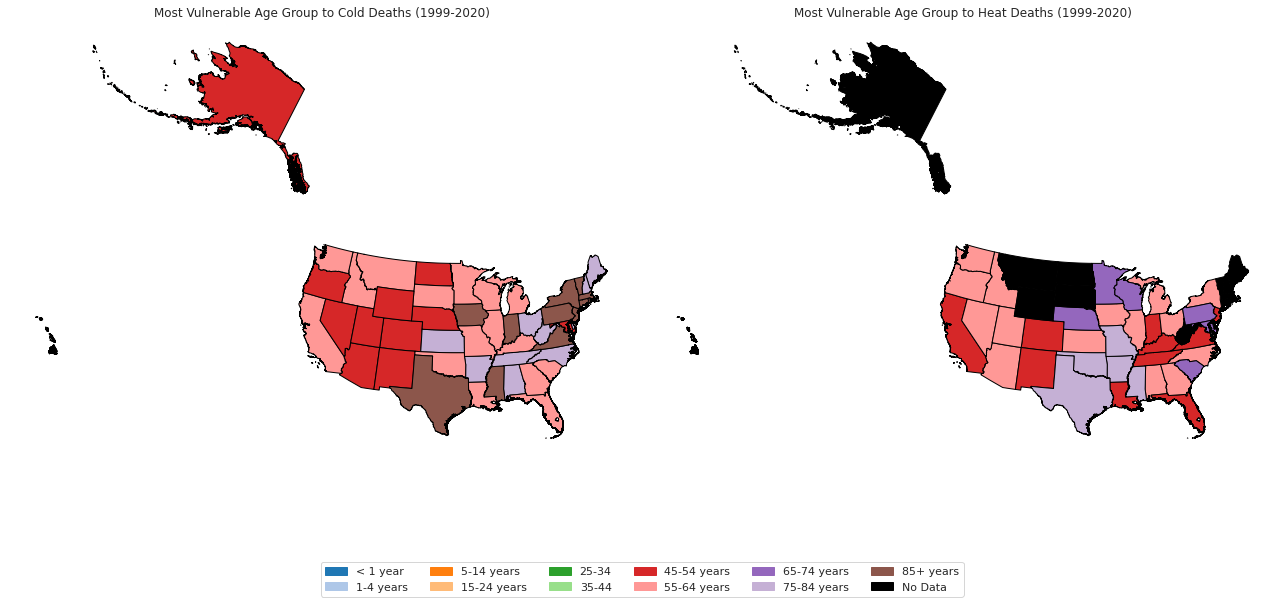

In [234]:
# Drop rows without geometries
gdf_cold_age = gdf_cold_age.dropna(subset=['geometry'])
gdf_heat_age = gdf_heat_age.dropna(subset=['geometry'])

# Drop rows without valid age groups
gdf_cold_age = gdf_cold_age.dropna(subset=['Ten-Year Age Groups'])
gdf_heat_age = gdf_heat_age.dropna(subset=['Ten-Year Age Groups'])

# Ensure all are strings
gdf_cold_age['Ten-Year Age Groups'] = gdf_cold_age['Ten-Year Age Groups'].astype(str)
gdf_heat_age['Ten-Year Age Groups'] = gdf_heat_age['Ten-Year Age Groups'].astype(str)

# Sort age groups logically (by numeric start or handle special cases)
def sort_key(age):
    if '<' in age:
        return -1
    if '85' in age:
        return 100
    match = re.search(r'\d+', age)
    return int(match.group()) if match else 999

# Define any age groups you want to always include
missing_groups = {"25-34", "35-44"}

# Combine all unique groups + the ones you want to include
age_groups = sorted(
    set(gdf_cold_age['Ten-Year Age Groups'])
    .union(gdf_heat_age['Ten-Year Age Groups'])
    .union(missing_groups),
    key=sort_key
)

# Assign colors in order
colors_list = plt.cm.tab20.colors
age_color_map = dict(zip(age_groups, colors_list[:len(age_groups)]))

# Apply color, black for zero deaths
def get_color(row):
    if row['Deaths'] == 0:
        return 'black'
    return age_color_map.get(row['Ten-Year Age Groups'], 'gray')

gdf_cold_age['color'] = gdf_cold_age.apply(get_color, axis=1)
gdf_heat_age['color'] = gdf_heat_age.apply(get_color, axis=1)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

gdf_cold_age.plot(color=gdf_cold_age['color'], edgecolor='black', ax=ax1)
ax1.set_title("Most Vulnerable Age Group to Cold Deaths (1999-2020)")
ax1.axis('off')

gdf_heat_age.plot(color=gdf_heat_age['color'], edgecolor='black', ax=ax2)
ax2.set_title("Most Vulnerable Age Group to Heat Deaths (1999-2020)")
ax2.axis('off')

# Create ordered legend
legend_patches = [patches.Patch(color=age_color_map[age], label=age) for age in age_groups]
legend_patches.append(patches.Patch(color='black', label='No Data'))

fig.legend(handles=legend_patches, loc='lower center', ncol=6)
plt.tight_layout()
plt.show()

**Analysis:** This map is a choropleth of the age group with the highest deaths for each state. To get this map we found the age group for each state with the most amount of deaths from 1999-2020 and merged them into a GeoDataFrame to add geometry for the values. This gives us an idea of which age group is most at risk for weather related deaths. States colored in black are no data because the values were suppressed for the age groups or 0. It'd be nice to scale down Alaska, and scale up Hawaii and then inset them for each of the maps.

In [235]:
print(f"Average mortality rate for cold related deaths across the US from 1999-2020: {gdf['cold_rate'].sum():.2f}")
print(f"Average mortality rate for heat related deaths across the US from 1999-2020: {gdf['heat_rate'].sum():.2f}")

Average mortality rate for cold related deaths across the US from 1999-2020: 0.09
Average mortality rate for heat related deaths across the US from 1999-2020: 0.03


In [250]:
gdf.to_file("/home/jovyan/project2/data/final_file2.shp")

## Introduction
Extreme temperatures pose significant risks to people across the United States. Both cold and heat can lead to death, but these mortality rates are not equal. Which type of extreme temperature causes more deaths? Do socioeconomic conditions play a role? Are certain age groups more affected than others?

This project aims to explore these questions by analyzing state level mortality data from 1999–2020, comparing deaths related to cold and heat across demographic and environmental factors. 

## **Hypothesis**:

*Across the United States, mortality rates associated with cold weather are higher than mortality rates associated with hot weather.*


## Data Explanation

We obtained mortality data from **CDC WONDER**, querying the *Multiple Cause of Death (1999–2020)* database. This includes cases where exposure to extreme temperatures was either the **underlying cause** or a **contributing factor** of death.  

**Cold-related deaths** were identified using the following ICD-10 codes:  
- **X31:** Exposure to excessive natural cold  
- **T68:** Hypothermia  

**Heat-related deaths** were identified using:  
- **X30:** Exposure to excessive natural heat  
- **T67:** Effects of heat and light  

For each state, we calculated the **average annual mortality rate** from 1999–2020 as:  

**Average Mortality Rate** = ((Temperature related deaths / Total population) × 100,000) / 21

This represents the **average number of deaths per 100,000 people per year** associated with the above ICD-10 codes.  

Weather data were obtained from the [**PRISM Climate Group**](https://asmith-agdata.shinyapps.io/prism_downloader/_w_a6c5076cc76b4c3fb50f4b256b4bafb5/#tab-5484-1), which provides daily minimum, mean, and maximum temperature data for each state.  
- **Cold days** were defined as those with a minimum temperature (**tmin**) below 0°C (32°F).  
- **Hot days** were defined as those with a maximum temperature (**tmax**) above 32°C (89.4°F).  

The number of hot and cold days per state was averaged across the 21-year period.  

Finally, **poverty percentages** were derived from datasets published by the **U.S. Census Bureau**, representing the average poverty rate per state across the same time span.  


## Analysis

In [251]:
gdf = gpd.read_file("/home/jovyan/project2/data/final_file2.shp")
gdf_sorted = gdf.sort_values('cold_rate', ascending=False)
states = gdf_sorted['STATE'] 
gdf_sorted.head()

,STATE,NAME,FIPS,LON,LAT,Heat Death,Cold Death,Population,cold_rate,heat_rate,hot_days,cold_days,death_rate,Poverty_pe,geometry
50,AK,ALASKA,02,-152.254696,64.242595,28.0,647.0,15300884.0,0.201358,0.008714,NaN,NaN,0.192644,10.387500,"MULTIPOLYGON (((-5208962.733 5574459.106, -520..."
46,WY,WYOMING,56,-107.551440,42.999630,23.0,242.0,12035143.0,0.095751,0.009100,4.476190,210.714286,0.086651,10.333333,"POLYGON ((-1028446.182 2517393.450, -1027404.5..."
23,MT,MONTANA,30,-109.645070,47.033500,37.0,427.0,21654987.0,0.093897,0.008136,9.190476,200.142857,0.085761,12.858333,"POLYGON ((-1348958.237 3018747.285, -1344538.2..."
29,NM,NEW MEXICO,35,-106.108370,34.421370,114.0,780.0,43978024.0,0.084458,0.012344,40.619048,134.285714,0.072114,18.708333,"POLYGON ((-1087965.512 1621641.299, -1086358.3..."
37,SD,SOUTH DAKOTA,46,-100.230480,44.436140,37.0,297.0,17936581.0,0.078849,0.009823,23.571429,177.714286,0.069026,11.800000,"POLYGON ((-515294.235 2568817.132, -514971.585..."


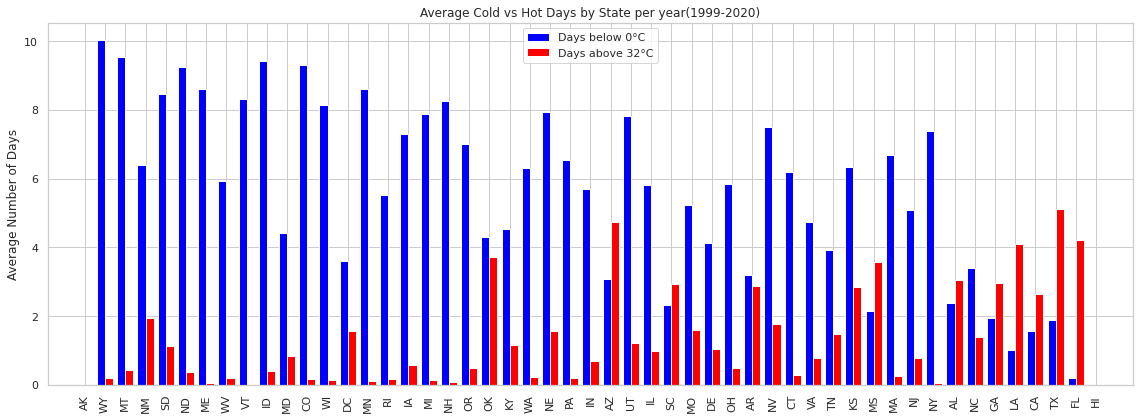

In [238]:
x = np.arange(len(states))
width = 0.4

fig, ax = plt.subplots(figsize=(16,6))
ax.bar(x - width/2, gdf_sorted['cold_days'], width, label='Days below 0°C', color='blue')
ax.bar(x + width/2, gdf_sorted['hot_days'], width, label='Days above 32°C', color='red')
ax.set_xticks(x)
ax.set_xticklabels(states, rotation=90)
ax.set_ylabel("Average Number of Days")
ax.set_title("Average Cold vs Hot Days by State per year(1999-2020)")
ax.legend()
plt.tight_layout()
plt.show()

This first plot is a simple bar chart comparing the average number of days below 0 degrees celsius (32 degrees farenheit) and above 32 degrees celsisus (89.4 degrees farenheit) for each state from 1999-2020. It seems that colder days are much more frequent than hot days.

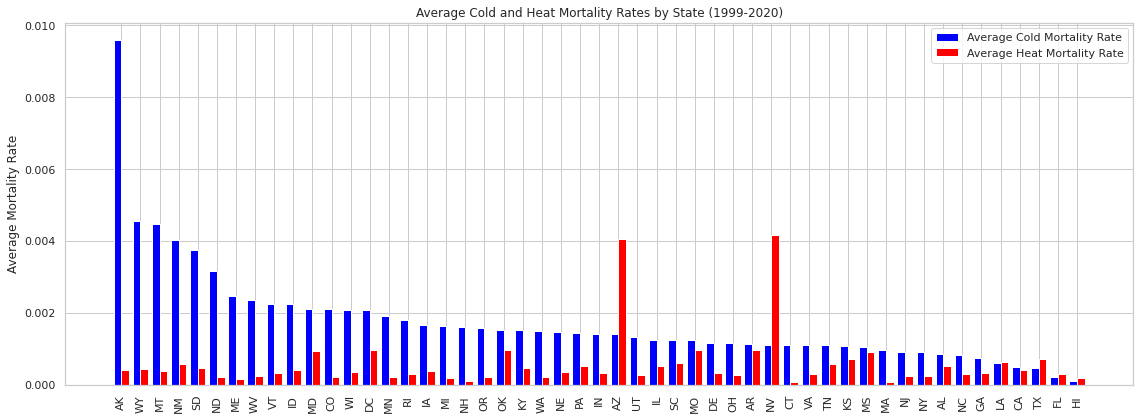

In [239]:
fig, ax = plt.subplots(figsize=(16,6))
ax.bar(x - width/2, gdf_sorted['cold_rate'], width, label='Average Cold Mortality Rate', color='blue')
ax.bar(x + width/2, gdf_sorted['heat_rate'], width, label='Average Heat Mortality Rate', color='red')
ax.set_xticks(x)
ax.set_xticklabels(states, rotation=90)
ax.set_ylabel("Average Mortality Rate")
ax.set_title("Average Cold and Heat Mortality Rates by State (1999-2020)")
ax.legend()
plt.tight_layout()
plt.show()

This bar chart represents the average mortality rate for cold and heat related deaths by state from 1999-2020. It seems that cold mortality rates seem to be greater in most of the states besides a select few such as Arizona and Nevada. 

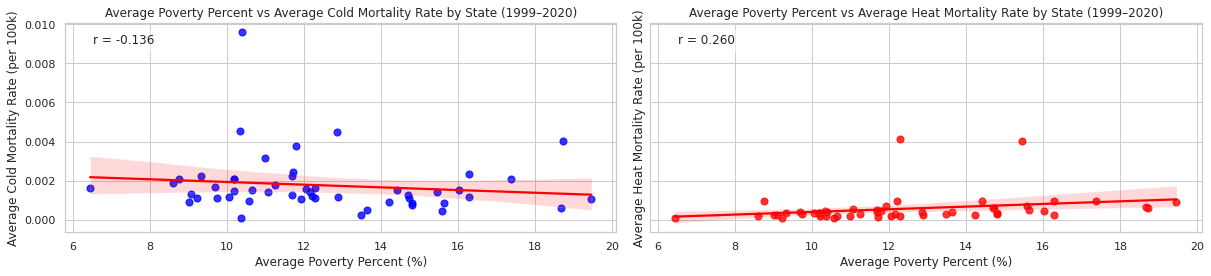

In [240]:
# Compute correlations
corr_cold = gdf['cold_rate'].corr(gdf['Poverty_pe'])
corr_heat = gdf['heat_rate'].corr(gdf['Poverty_pe'])

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 4), sharex=True, sharey=True)

# --- Left: Cold Deaths ---
sns.regplot(
    x='Poverty_pe', 
    y='cold_rate', 
    data=gdf, 
    scatter_kws={'s':50, 'color':'blue'}, 
    line_kws={'color':'red'},
    ax=ax1
)
ax1.set_title("Average Poverty Percent vs Average Cold Mortality Rate by State (1999–2020)")
ax1.set_xlabel("Average Poverty Percent (%)")
ax1.set_ylabel("Average Cold Mortality Rate (per 100k)")
ax1.text(0.05, 0.9, f'r = {corr_cold:.3f}', transform=ax1.transAxes,
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

# --- Right: Heat Deaths ---
sns.regplot(
    x='Poverty_pe', 
    y='heat_rate', 
    data=gdf, 
    scatter_kws={'s':50, 'color':'red'}, 
    line_kws={'color':'red'},
    ax=ax2
)
ax2.set_title("Average Poverty Percent vs Average Heat Mortality Rate by State (1999–2020)")
ax2.set_xlabel("Average Poverty Percent (%)")
ax2.set_ylabel("Average Heat Mortality Rate (per 100k)") 
ax2.text(0.05, 0.9, f'r = {corr_heat:.3f}', transform=ax2.transAxes,
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

These scatterplots are seeing if there is any correlation between the mortality rates and the poverty percent for each state. Cold mortality rates seem to have a negative correlation, while heat mortality rates have a positive one. This is opposite of what we would have thought, but may suggest that people in poverty have more access to infrastructure with heat during cold months.

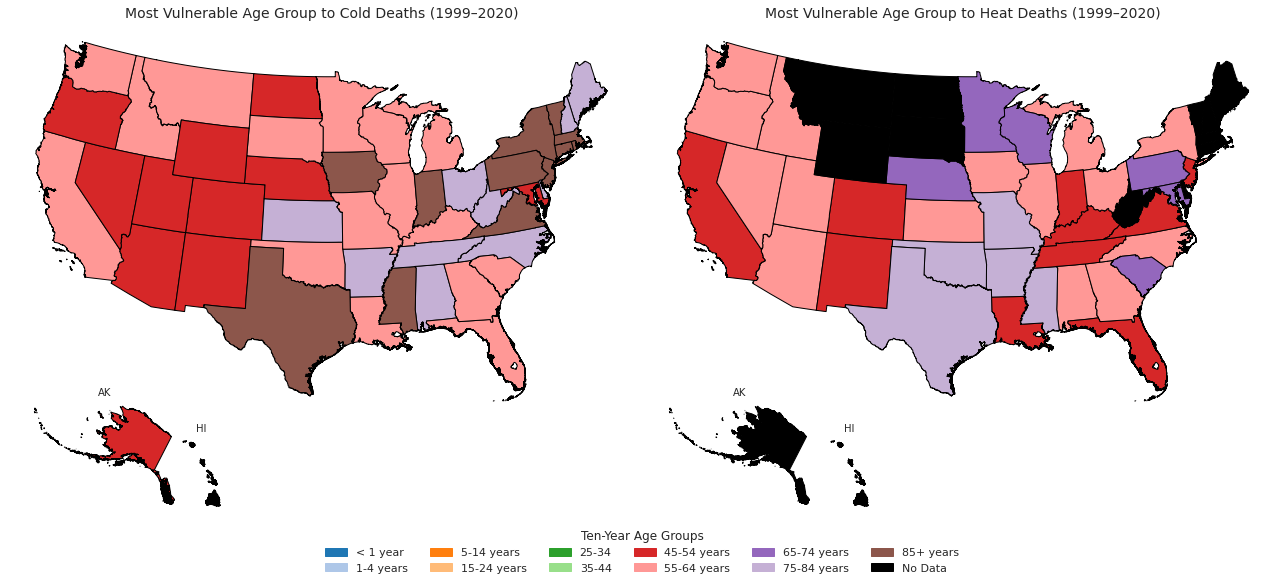

In [241]:
# --- Separate contiguous US, AK, HI ---
gdf_cold_contig = gdf_cold_age[~gdf_cold_age['State'].isin(['Alaska', 'Hawaii'])]
gdf_heat_contig = gdf_heat_age[~gdf_heat_age['State'].isin(['Alaska', 'Hawaii'])]

gdf_cold_ak = gdf_cold_age[gdf_cold_age['State'] == 'Alaska']
gdf_heat_ak = gdf_heat_age[gdf_heat_age['State'] == 'Alaska']

gdf_cold_hi = gdf_cold_age[gdf_cold_age['State'] == 'Hawaii']
gdf_heat_hi = gdf_heat_age[gdf_heat_age['State'] == 'Hawaii']

# --- Plot main US map ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))
gdf_cold_contig.plot(color=gdf_cold_contig['color'], edgecolor='black', ax=ax1)
gdf_heat_contig.plot(color=gdf_heat_contig['color'], edgecolor='black', ax=ax2)
ax1.set_title("Most Vulnerable Age Group to Cold Deaths (1999–2020)", fontsize=14)
ax2.set_title("Most Vulnerable Age Group to Heat Deaths (1999–2020)", fontsize=14)
ax1.axis('off')
ax2.axis('off')

# --- Add insets for Alaska ---
ax_ak = fig.add_axes([0.01, 0.1, 0.15, 0.15])  # [left, bottom, width, height]
gdf_cold_ak.plot(color=gdf_cold_ak['color'], edgecolor='black', ax=ax_ak)
ax_ak.axis('off')
ax_ak.set_title("AK", fontsize=10)

ax_ak2 = fig.add_axes([0.5, 0.1, 0.15, 0.15])
gdf_heat_ak.plot(color=gdf_heat_ak['color'], edgecolor='black', ax=ax_ak2)
ax_ak2.axis('off')
ax_ak2.set_title("AK", fontsize=10)

# --- Add insets for Hawaii ---
ax_hi = fig.add_axes([0.11, 0.1, 0.1, 0.1])
gdf_cold_hi.plot(color=gdf_cold_hi['color'], edgecolor='black', ax=ax_hi)
ax_hi.axis('off')
ax_hi.set_title("HI", fontsize=10)

ax_hi2 = fig.add_axes([0.61, 0.1, 0.1, 0.1])
gdf_heat_hi.plot(color=gdf_heat_hi['color'], edgecolor='black', ax=ax_hi2)
ax_hi2.axis('off')
ax_hi2.set_title("HI", fontsize=10)
        
# --- Add legend ---
legend_patches = [patches.Patch(color=age_color_map[age], label=age) for age in age_groups]
legend_patches.append(patches.Patch(color='black', label='No Data'))
fig.legend(handles=legend_patches, loc='lower center', ncol=6, title="Ten-Year Age Groups", frameon=False)

plt.tight_layout()
plt.show()

This choropleth represents which ten-year age group has the most cold and heat related deaths. For both maps it seems that people 45 and older are most affected. 

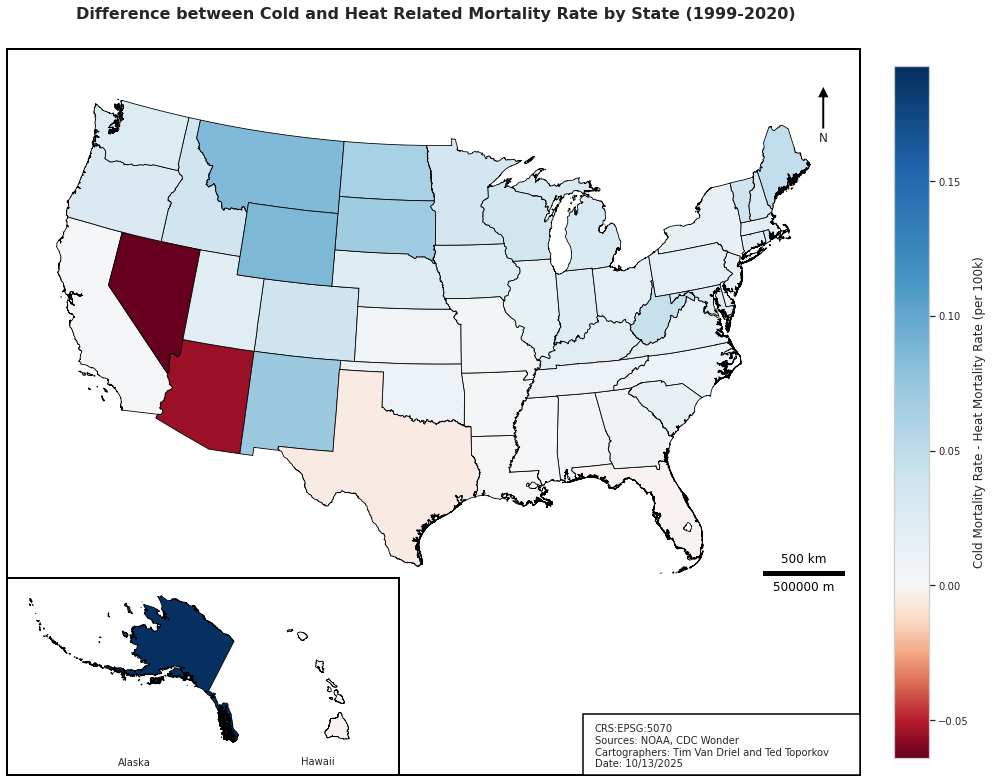

In [281]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors

# Separate contiguous US, Alaska, Hawaii for insets
contig = gdf[~gdf['FIPS'].isin(['02', '15'])]
alaska = gdf[gdf['FIPS'] == '02']
hawaii = gdf[gdf['FIPS'] == '15']

# Create figure
fig = plt.figure(figsize=(16, 42))

# Define normalization for consistent coloring with better contrast
# Using full data range without forcing symmetry (better contrast)
vmin = gdf['death_rate'].min()
vmax = gdf['death_rate'].max()
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Main map (contiguous US)
ax_main = fig.add_axes([0.05, 0.75, 0.9, 0.22])
plot = contig.plot(
    column='death_rate',
    cmap='RdBu',
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    legend_kwds={'label': "Cold Mortality Rate - Heat Mortality Rate (per 100k)"},
    ax=ax_main,
    norm=norm
)
ax_main.axis('off')

# Adjust colorbar position and formatting
cbar_ax = plot.get_figure().axes[-1]
cbar_ax.set_position([0.81, 0.715, 0.03, 0.24])
cbar_ax.tick_params(labelsize=10)

# Title
fig.text(
    0.1, 0.965,
    "Difference between Cold and Heat Related Mortality Rate by State (1999-2020)",
    fontsize=16,
    fontweight='bold',
    ha='left'
)

# Alaska inset
ax_ak = fig.add_axes([0.05, 0.69, 0.2, 0.12])
alaska.plot(column='death_rate', cmap='RdBu', linewidth=0.8, 
            edgecolor='black', ax=ax_ak, norm=norm)
ax_ak.axis('off')
ax_ak.text(0.5, -0.05, "Alaska", ha='center', va='top', 
           fontsize=10, transform=ax_ak.transAxes)

# Hawaii inset
ax_hi = fig.add_axes([0.28, 0.725, 0.06, 0.04])
hawaii.plot(column='death_rate', cmap='RdBu', linewidth=0.8, 
            edgecolor='black', ax=ax_hi, norm=norm)
ax_hi.axis('off')
ax_hi.text(0.5, -0.1, "Hawaii", ha='center', va='top', 
           fontsize=10, transform=ax_hi.transAxes)

# Rectangle around insets
rect_insets = patches.Rectangle(
    (0.04, 0.715), 0.34, 0.065,
    linewidth=2, edgecolor='black', facecolor='none',
    transform=fig.transFigure
)
fig.patches.append(rect_insets)

# Main rectangle around entire map area
rect_main = patches.FancyBboxPatch(
    (0.04, 0.715), 0.74, 0.24,
    boxstyle="square,pad=0",
    fill=False, linewidth=2, edgecolor='black',
    transform=fig.transFigure
)
fig.patches.append(rect_main)

# North arrow
ax_main.annotate(
    'N',
    xy=(0.97, 0.98), xytext=(0.97, 0.88),
    arrowprops=dict(facecolor='black', width=3, headwidth=12),
    ha='center', va='center', fontsize=12,
    xycoords='axes fraction'
)

# Information box
info_text = (
    "CRS:EPSG:5070\n"
    "Sources: NOAA, CDC Wonder\n"
    "Cartographers: Tim Van Driel and Ted Toporkov\n"
    "Date: 10/13/2025"
)
rect_info = patches.Rectangle(
    (0.54, 0.715), 0.24, 0.02,
    linewidth=1.5, edgecolor='black', facecolor='white',
    transform=fig.transFigure
)
fig.patches.append(rect_info)
fig.text(0.55, 0.717, info_text, fontsize=10, va='bottom', ha='left')
from matplotlib_scalebar.scalebar import ScaleBar

# Each map unit = 1 meter. We want a 500 km scale bar.
scalebar = ScaleBar(
    dx=1,                # 1 map unit = 1 meter
    units="m",           # map units are meters
    dimension="si-length",
    length_fraction=0.25, # fraction of the axes width
    location='lower right',
    box_alpha=0.7,
    color='black',
    fixed_value=500_000,  # 500 km in meters
    fixed_units='m',
    label='500 km'        # override label to display km
)

# Add to main Axes
ax_main.add_artist(scalebar)

plt.show()

_Note: Alaska and Hawaii are not to scale_

This choropleth show the difference between cold and heat mortality rates for each state. There appears to be more states colored in blue then red. This tells us that overall cold mortality rates are higher.

| Variable             | Moran's I | p-value  |
|----------------------|-----------|----------|
| Death Rate Difference| 0.218     | 0.0120   |
| Cold Mortality Rate  | 0.193     | 0.0150   |
| Heat Mortality Rate  | 0.172     | 0.0310   |


Moran’s I measures spatial autocorrelation, indicating whether similar values cluster geographically. The difference in mortality rates had a Moran’s I of 0.218 (p = 0.012), cold mortality 0.193 (p = 0.015), and heat mortality 0.172 (p = 0.031), all showing statistically significant positive spatial clustering. This suggests that states with similar mortality rates tend to be near each other rather than randomly distributed.

| Type of Mortality     | Rate (per 100,000) | Year/Period                  |
|-----------------------|------------------|------------------------------|
| Drug Overdose         | 32.4             | 2021                         |
| Homicide              | 5.9              | 2023                         |
| Cold related Mortality| 1.89             | Average 1999–2020            |
| Heat related Mortality| 0.61             | Average 1999–2020            |
                                                         


This table provides a comparison of mortality rates in the United States for selected causes. Cold related deaths (1.89 per 100,000) occur at a higher rate than heatrelated deaths (0.61 per 100,000), but both are substantially lower than deaths due to homicide (5.9 per 100,000) and drug overdose (32.4 per 100,000). 

## Conclusion
The first plot, a bar chart showing cold and hot days by state, indicates that most states experience more cold days (blue) than hot days (red). This helps explain why cold related mortality is generally higher.

The second plot, a bar chart comparing cold (blue) and heat (red) mortality rates by state, reinforces this trend. With the exception of Arizona and Nevada, cold related mortality rates are consistently higher than heat related rates.

The third plot, a scatterplot comparing poverty percentage to mortality rates, provides insight into potential socioeconomic effects. Cold mortality shows a slight negative correlation with poverty, while heat mortality shows a slightly stronger positive correlation. This may suggest that people in poverty have better access to heating during cold periods but limited access to air conditioning during heat waves, though further study would be needed to confirm this.

The fourth plot, a pair of choropleths showing the most affected age groups for cold and heat related deaths, highlights that different age groups are more vulnerable depending on temperature extremes.

The fifth and final plot, a choropleth of the difference in mortality rates, provides the strongest support for our hypothesis. Positive values (blue) indicate higher cold related mortality, while negative values (red) indicate higher heat related mortality. Most states are shaded light to moderate blue, showing that cold-related deaths are generally higher. Alaska exhibits the largest difference, whereas Arizona and Nevada have higher heat-related mortality.

Spatial analysis using Moran’s I autocorrelation confirms that states with similar mortality rates are geographically clustered rather than randomly distributed, with all Moran’s I values positive and p-values < 0.05.

Finally, the average mortality rate from 1999 to 2020 was 1.89 per 100,000 for cold-related deaths and 0.61 per 100,000 for heat-related deaths, confirming that cold-related mortality is substantially higher across the U.S. over this period. However, this is relatively small compared to other mortality rates, such as drug overdose.

### Sources
- CDC Wonder: https://wonder.cdc.gov
- PRISM Weather Data: https://asmith-agdata.shinyapps.io/prism_downloader/_w_a6c5076cc76b4c3fb50f4b256b4bafb5/#tab-5484-1
- State Shapefile: https://www.weather.gov/gis/USStates
- United States Census Bureau: https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-poverty-people.html
- County Shapefile (not used for final visuals): https://catalog.data.gov/dataset/tiger-line-shapefile-2019-nation-u-s-current-county-and-equivalent-national-shapefile
- Homicide Mortality Rate: https://bjs.ojp.gov/document/hvus23.pdf
- Drug Overdose Mortality Rate: https://www.cdc.gov/nchs/nvss/drug-overdose-deaths.htm
- ChatGPT: Prompted for creating and editing plots, and reading in/filtering poverty data